In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Data loading and initial processing
def load_heathrow_data(file_path):
    """
    Load and process Heathrow temperature data with robust handling of the specific file format.
    """
    # Read the raw text file
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Process only data lines
    data_lines = []
    for line in lines:
        # Skip header lines and empty lines
        if line.strip() and line.strip()[0].isdigit():
            # Split by whitespace and take first 7 columns
            values = line.strip().split()[:7]
            # Only add if we have all required columns
            if len(values) >= 7:
                data_lines.append(values)
    
    # Create DataFrame with specified columns
    df = pd.DataFrame(data_lines, 
                     columns=['year', 'month', 'tmax', 'tmin', 'af', 'rain', 'sun'])
    
    # Convert data types and handle missing values
    numeric_columns = ['year', 'month', 'tmax', 'tmin', 'rain']
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
    
    # Calculate temperature variability metrics
    df['temp_range'] = df['tmax'] - df['tmin']
    df['month_str'] = df['month'].astype(str).str.zfill(2)
    df['date'] = pd.to_datetime(df['year'].astype(str) + df['month_str'], format='%Y%m')
    
    return df
# Load and prepare the data
df = load_heathrow_data('heathrowdata.txt')

In [12]:
# display(HTML(df.to_html()))

/var/folders/ss/7gdz3mj52njb_7zt7jv9wj2r0000gp/T/ipykernel_43952/3047698691.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


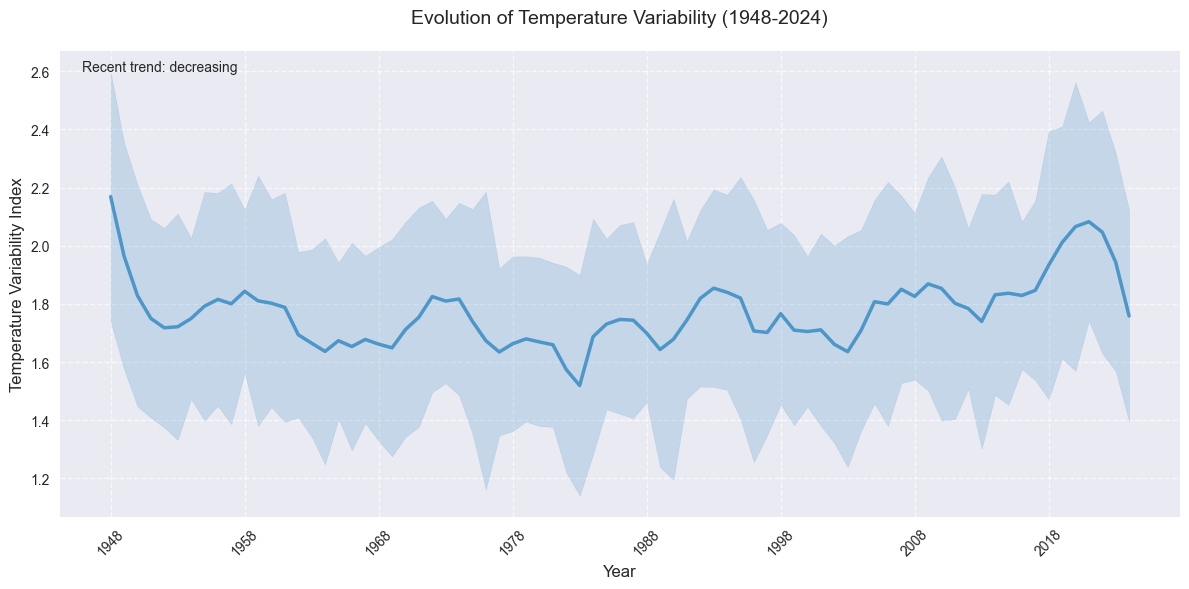

In [11]:
from scipy.signal import savgol_filter
import matplotlib.dates as mdates

def create_variability_trend_plot(df):
    """
    Generate a sophisticated visualization of temperature variability trends
    using advanced smoothing techniques for enhanced interpretability.
    """
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Calculate yearly averages for smoother trend
    yearly_stats = df.groupby('year')['temp_range'].agg(['mean', 'std']).reset_index()
    
    # Apply Savitzky-Golay filter for trend smoothing
    window_length = 15  # Must be odd number
    poly_order = 3
    smoothed_variability = savgol_filter(yearly_stats['std'], window_length, poly_order)
    
    # Create the plot
    ax.plot(yearly_stats['year'], 
            smoothed_variability, 
            color='#2E86C1', 
            linewidth=2.5,
            alpha=0.8)
    
    # Add confidence interval
    ax.fill_between(yearly_stats['year'],
                    smoothed_variability - yearly_stats['std']*0.2,
                    smoothed_variability + yearly_stats['std']*0.2,
                    color='#2E86C1',
                    alpha=0.2)
    
    # Customize the plot
    ax.set_title('Evolution of Temperature Variability (1948-2024)',
                fontsize=14, pad=20)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Temperature Variability Index', fontsize=12)
    
    # Add grid and customize ticks
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xticks(yearly_stats['year'][::10])  # Show every 10th year
    plt.xticks(rotation=45)
    
    # Add trend annotation
    recent_trend = smoothed_variability[-1] - smoothed_variability[-20]
    trend_direction = "increasing" if recent_trend > 0 else "decreasing"
    ax.text(0.02, 0.98, 
            f'Recent trend: {trend_direction}',
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment='top')
    
    plt.tight_layout()
    return fig, ax

# Create the plot
fig, ax = create_variability_trend_plot(df)
plt.show()

/var/folders/ss/7gdz3mj52njb_7zt7jv9wj2r0000gp/T/ipykernel_43952/2757730480.py:79: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


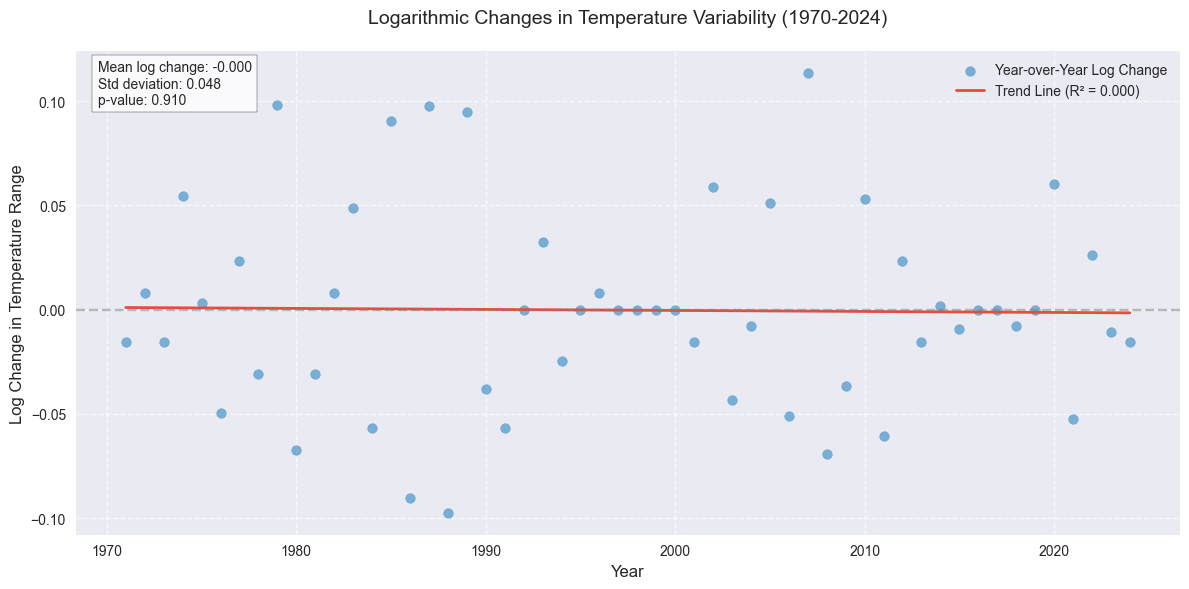


Logarithmic Change Analysis:
Mean annual log change: -0.000
Standard deviation of log changes: 0.048
Trend significance (p-value): 0.910

Volatility Metrics:
Positive changes: 23 years
Negative changes: 27 years
Largest increase: 0.114 (Year: 2007)
Largest decrease: -0.097 (Year: 1988)


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

def process_temperature_data(file_path, start_year=1970):
    """
    Process UK temperature data focusing on logarithmic changes in variability.
    This approach enables analysis of proportional changes rather than absolute differences.
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    data = []
    data_started = False
    
    for line in lines:
        if line.strip().startswith('jan'):
            data_started = True
            continue
            
        if data_started and line.strip() and not line.startswith('Source'):
            values = line.strip().split()
            try:
                year = int(values[1])
                if year >= start_year:
                    monthly_temps = []
                    for i in range(0, len(values)-1, 2):
                        try:
                            temp = float(values[i])
                            monthly_temps.append(temp)
                        except ValueError:
                            continue
                    
                    if monthly_temps:
                        temp_range = max(monthly_temps) - min(monthly_temps)
                        data.append({
                            'year': year,
                            'temp_range': temp_range,
                            'max_temp': max(monthly_temps),
                            'min_temp': min(monthly_temps)
                        })
            except (ValueError, IndexError):
                continue
    
    # Create DataFrame and calculate log changes
    df = pd.DataFrame(data)
    df = df.sort_values('year')
    
    # Calculate year-over-year log changes
    df['log_change'] = np.log(df['temp_range'] / df['temp_range'].shift(1))
    
    return df.dropna()  # Remove NaN values from first year's log change

def analyze_log_trends(df):
    """
    Analyze trends in logarithmic changes, providing insights into
    the rate of change in temperature variability.
    """
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        df['year'], df['log_change']
    )
    
    df['trend'] = df['year'] * slope + intercept
    
    return {
        'slope': slope,
        'r_squared': r_value**2,
        'p_value': p_value,
        'mean_log_change': df['log_change'].mean(),
        'std_log_change': df['log_change'].std()
    }

def visualize_log_changes(df, metrics):
    """
    Create a sophisticated visualization of logarithmic changes in temperature variability.
    """
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot log changes
    ax.scatter(df['year'], df['log_change'], 
              alpha=0.6, color='#2E86C1', 
              label='Year-over-Year Log Change')
    
    # Plot trend line
    ax.plot(df['year'], df['trend'], 
            color='#E74C3C', linewidth=2, 
            label=f'Trend Line (R² = {metrics["r_squared"]:.3f})')
    
    # Add horizontal line at y=0 for reference
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    # Customize plot
    ax.set_title('Logarithmic Changes in Temperature Variability (1970-2024)',
                fontsize=14, pad=20)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Log Change in Temperature Range', fontsize=12)
    
    # Add grid and customize appearance
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', labelsize=10)
    
    # Add trend information
    trend_text = (
        f'Mean log change: {metrics["mean_log_change"]:.3f}\n'
        f'Std deviation: {metrics["std_log_change"]:.3f}\n'
        f'p-value: {metrics["p_value"]:.3f}'
    )
    ax.text(0.02, 0.98, trend_text,
            transform=ax.transAxes,
            verticalalignment='top',
            fontsize=10,
            bbox=dict(facecolor='white', alpha=0.8))
    
    plt.legend()
    plt.tight_layout()
    
    return fig, ax

# Execute the analysis
df = process_temperature_data('UK_weather_data.txt')
metrics = analyze_log_trends(df)

# Create visualization
fig, ax = visualize_log_changes(df, metrics)
plt.show()

# Display comprehensive statistical summary
print("\nLogarithmic Change Analysis:")
print(f"Mean annual log change: {metrics['mean_log_change']:.3f}")
print(f"Standard deviation of log changes: {metrics['std_log_change']:.3f}")
print(f"Trend significance (p-value): {metrics['p_value']:.3f}")

# Additional volatility metrics
print("\nVolatility Metrics:")
print(f"Positive changes: {(df['log_change'] > 0).sum()} years")
print(f"Negative changes: {(df['log_change'] < 0).sum()} years")
print(f"Largest increase: {df['log_change'].max():.3f} "
      f"(Year: {df.loc[df['log_change'].idxmax(), 'year']})")
print(f"Largest decrease: {df['log_change'].min():.3f} "
      f"(Year: {df.loc[df['log_change'].idxmin(), 'year']})")

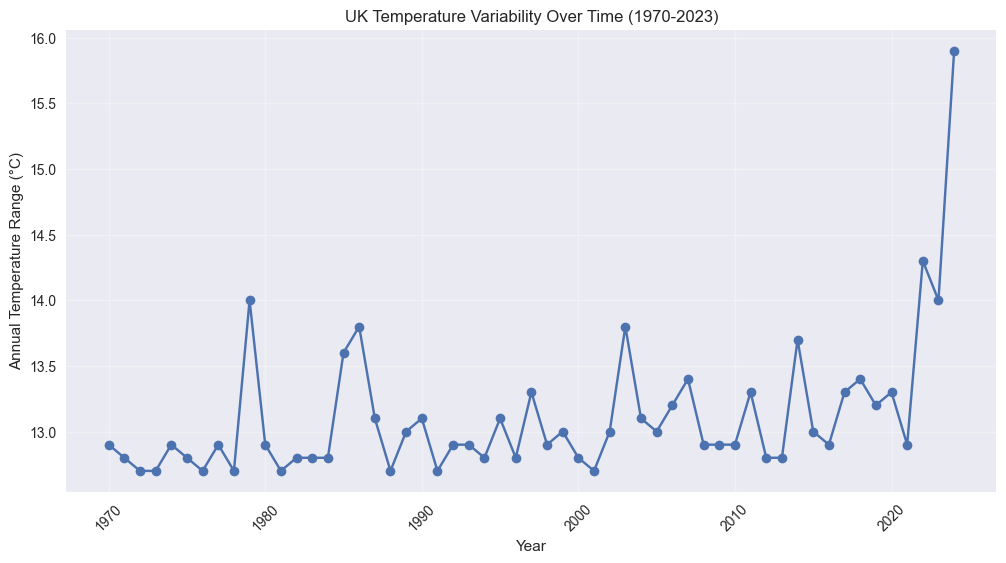

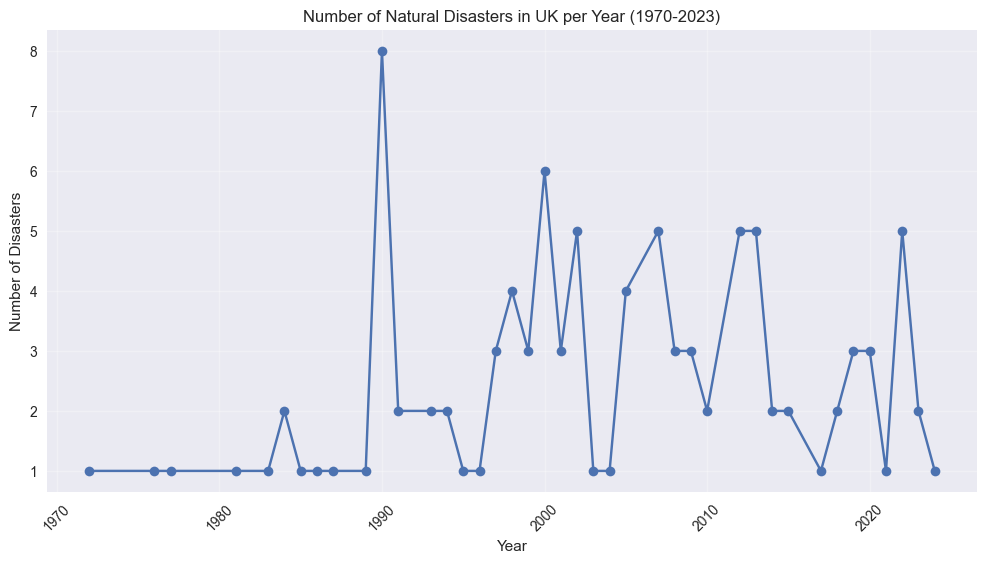

<Figure size 800x550 with 0 Axes>


Temperature Variability Summary:
             year  temperature_range
count    55.00000          55.000000
mean   1997.00000          13.114545
std      16.02082           0.536594
min    1970.00000          12.700000
25%    1983.50000          12.800000
50%    1997.00000          12.900000
75%    2010.50000          13.250000
max    2024.00000          15.900000

Disaster Counts Summary:
              year  disaster_count
count    41.000000       41.000000
mean   2000.975610        2.487805
std      14.383129        1.719331
min    1972.000000        1.000000
25%    1990.000000        1.000000
50%    2001.000000        2.000000
75%    2013.000000        3.000000
max    2024.000000        8.000000


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def process_temperature_data(data_text):
    """Process UK temperature data from text file"""
    # Split into lines and get data rows (skip headers)
    lines = [line for line in data_text.strip().split('\n') if line.strip()]
    data_lines = lines[4:]  # Skip header rows
    
    years = []
    monthly_temps = []
    
    for line in data_lines:
        parts = line.split()
        
        # Extract year (last column) if numeric
        if parts[-1].replace('.', '', 1).isdigit():
            year = int(float(parts[-1]))
            if year >= 1970:
                # Get monthly temperatures (first 12 pairs of columns)
                temps = []
                for i in range(0, 24, 2):  # Step by 2 to skip year columns
                    if parts[i] != '---':
                        temps.append(float(parts[i]))
                
                if temps:  # If we have valid temperatures
                    temp_range = max(temps) - min(temps)
                    monthly_temps.append(temp_range)
                    years.append(year)
    
    df = pd.DataFrame({
        'year': years,
        'temperature_range': monthly_temps
    })
    return df.sort_values('year')

def plot_temperature_trends(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['year'], df['temperature_range'], marker='o')
    plt.title('UK Temperature Variability Over Time (1970-2023)')
    plt.xlabel('Year')
    plt.ylabel('Annual Temperature Range (°C)')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    return plt

def process_disaster_data(df):
    """Process UK natural disaster data from CSV"""
    # Convert year columns to numeric
    df['Start Year'] = pd.to_numeric(df['Start Year'], errors='coerce')
    
    # Filter for years >= 1970
    df_filtered = df[df['Start Year'] >= 1970].copy()
    
    # Count disasters per year
    yearly_counts = df_filtered.groupby('Start Year').size().reset_index()
    yearly_counts.columns = ['year', 'disaster_count']
    
    return yearly_counts.sort_values('year')

def plot_disaster_trends(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['year'], df['disaster_count'], marker='o')
    plt.title('Number of Natural Disasters in UK per Year (1970-2023)')
    plt.xlabel('Year')
    plt.ylabel('Number of Disasters')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    return plt

# Read the data
with open('UK_weather_data.txt', 'r') as file:
    temp_data = file.read()

disasters_df = pd.read_csv('UK Natural Disasters Data - EM-DAT Data.csv')

# Process and plot temperature data
temp_df = process_temperature_data(temp_data)
temp_plot = plot_temperature_trends(temp_df)
plt.figure(1)
plt.show()

# Process and plot disaster data
disaster_df = process_disaster_data(disasters_df)
disaster_plot = plot_disaster_trends(disaster_df)
plt.figure(2)
plt.show()

# Print summary statistics
print("\nTemperature Variability Summary:")
print(temp_df.describe())
print("\nDisaster Counts Summary:")
print(disaster_df.describe())

/var/folders/ss/7gdz3mj52njb_7zt7jv9wj2r0000gp/T/ipykernel_49260/381266389.py:46: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


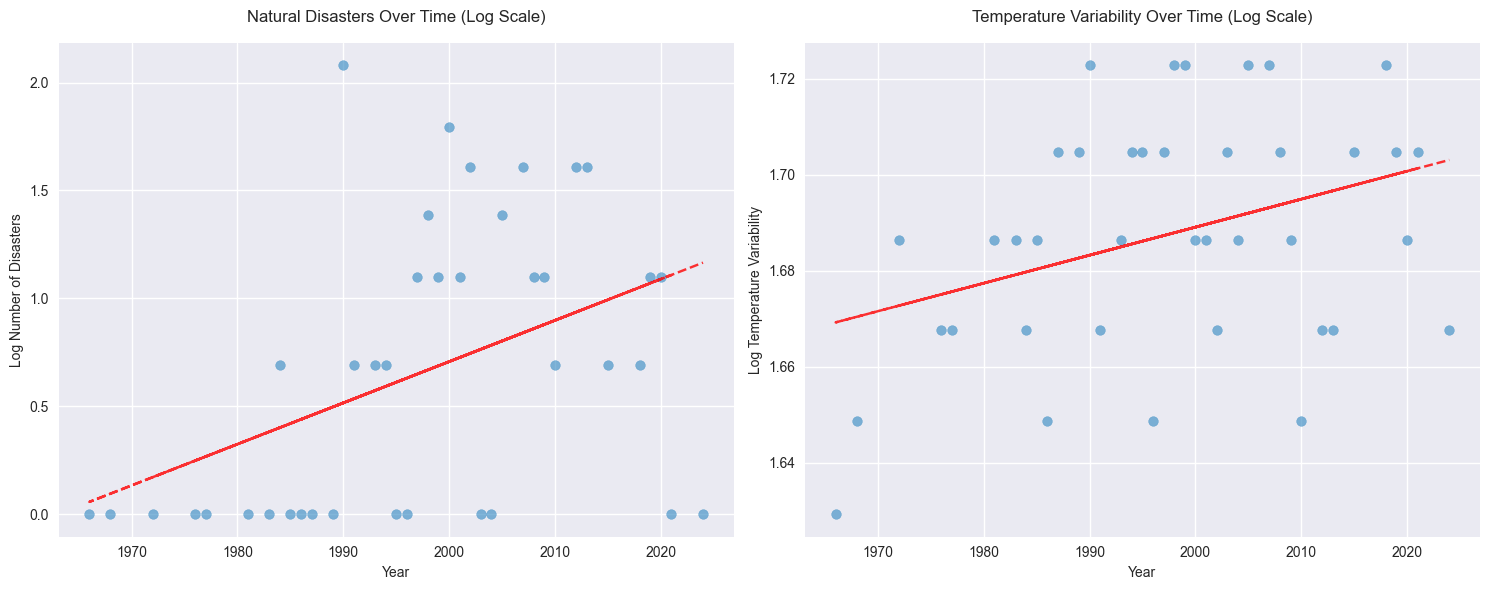

Disasters trend - R² = 0.191, p = 0.005
Temperature variability trend - R² = 0.129, p = 0.025


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def process_temp_data(min_temp_file, max_temp_file, start_year=1960):
    with open(min_temp_file, 'r') as f:
        min_lines = f.readlines()[11:]  # Skip headers
    with open(max_temp_file, 'r') as f:    
        max_lines = f.readlines()[11:]
        
    years, variability = [], []
    
    for min_line, max_line in zip(min_lines, max_lines):
        min_vals = min_line.strip().split()
        max_vals = max_line.strip().split()
        
        if not min_vals or not max_vals:
            continue
            
        try:
            year = int(min_vals[-1])
            if year < start_year:
                continue
            min_temp = float(min_vals[0]) 
            max_temp = float(max_vals[0])
            years.append(year)
            variability.append(max_temp - min_temp)
        except (ValueError, IndexError):
            continue
            
    return pd.DataFrame({'year': years, 'temp_variability': variability})

def process_disaster_data(disaster_file, start_year=1960):
    df = pd.read_csv(disaster_file)
    yearly_disasters = df.groupby('Start Year').size().reset_index(name='disaster_count')
    return yearly_disasters[yearly_disasters['Start Year'] >= start_year].rename(columns={'Start Year': 'year'})

# Process data
temp_data = process_temp_data('UK_min_temperature_data.txt', 'UK_max_temperature_data.txt')
disaster_data = process_disaster_data('UK Natural Disasters Data - EM-DAT Data.csv')
merged_data = pd.merge(temp_data, disaster_data, on='year', how='inner')

# Create figure
plt.style.use('seaborn')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Disasters over time
ax1.scatter(merged_data['year'], np.log(merged_data['disaster_count']), c='#2E86C1', alpha=0.6)
z1 = np.polyfit(merged_data['year'], np.log(merged_data['disaster_count']), 1)
p1 = np.poly1d(z1)
ax1.plot(merged_data['year'], p1(merged_data['year']), "r--", alpha=0.8)
ax1.set_title('Natural Disasters Over Time (Log Scale)', fontsize=12, pad=15)
ax1.set_xlabel('Year', fontsize=10)
ax1.set_ylabel('Log Number of Disasters', fontsize=10)

# Plot 2: Temperature variability over time  
ax2.scatter(merged_data['year'], np.log(merged_data['temp_variability']), c='#2E86C1', alpha=0.6)
z2 = np.polyfit(merged_data['year'], np.log(merged_data['temp_variability']), 1)
p2 = np.poly1d(z2)
ax2.plot(merged_data['year'], p2(merged_data['year']), "r--", alpha=0.8)
ax2.set_title('Temperature Variability Over Time (Log Scale)', fontsize=12, pad=15)
ax2.set_xlabel('Year', fontsize=10)
ax2.set_ylabel('Log Temperature Variability', fontsize=10)

# Layout
plt.tight_layout()
plt.show()

# Print statistics
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(merged_data['year'], np.log(merged_data['disaster_count']))
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(merged_data['year'], np.log(merged_data['temp_variability']))

print(f'Disasters trend - R² = {r_value1**2:.3f}, p = {p_value1:.3f}')
print(f'Temperature variability trend - R² = {r_value2**2:.3f}, p = {p_value2:.3f}')

/var/folders/ss/7gdz3mj52njb_7zt7jv9wj2r0000gp/T/ipykernel_49260/708285031.py:43: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


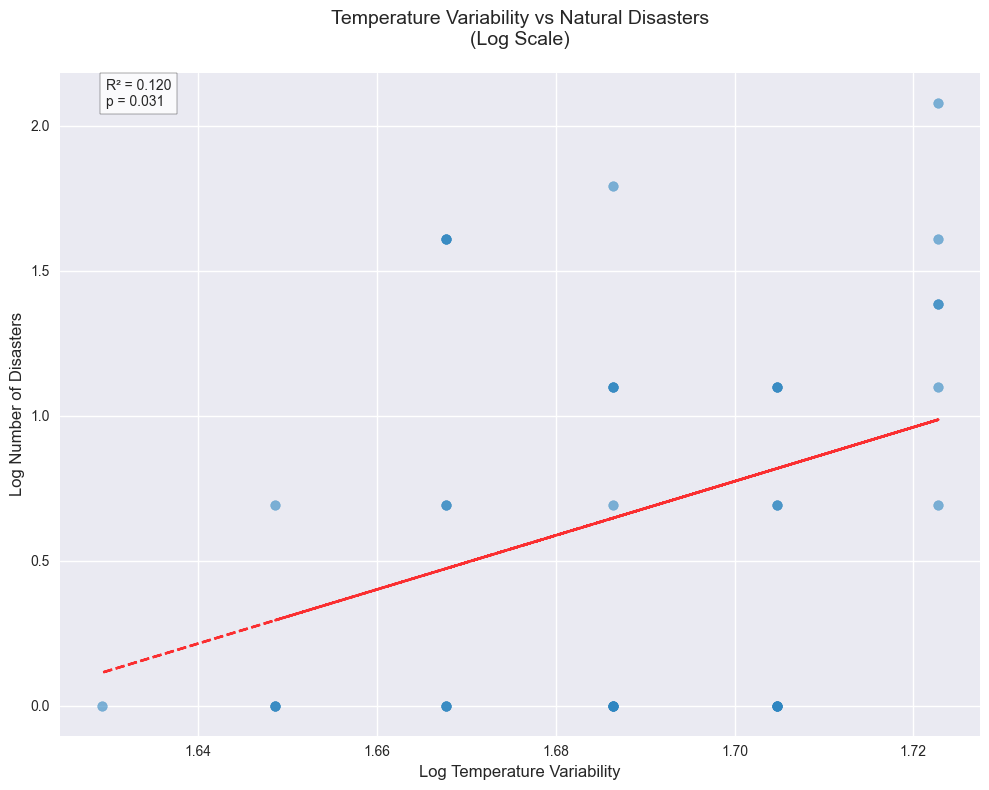

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def process_data(min_temp_file, max_temp_file, disaster_file, start_year=1960):
   # Process temperature data
   with open(min_temp_file, 'r') as f:
       min_lines = f.readlines()[11:]
   with open(max_temp_file, 'r') as f:    
       max_lines = f.readlines()[11:]
       
   years, variability = [], []
   for min_line, max_line in zip(min_lines, max_lines):
       try:
           year = int(min_line.strip().split()[-1])
           if year < start_year:
               continue
           min_temp = float(min_line.strip().split()[0])
           max_temp = float(max_line.strip().split()[0])
           years.append(year)
           variability.append(max_temp - min_temp)
       except (ValueError, IndexError):
           continue
           
   temp_df = pd.DataFrame({'year': years, 'temp_variability': variability})
   
   # Process disaster data
   disaster_df = pd.read_csv(disaster_file)
   disaster_df = disaster_df.groupby('Start Year').size().reset_index(name='disaster_count')
   disaster_df = disaster_df[disaster_df['Start Year'] >= start_year].rename(columns={'Start Year': 'year'})
   
   # Merge datasets
   return pd.merge(temp_df, disaster_df, on='year', how='inner')

# Load and process data
data = process_data('UK_min_temperature_data.txt', 'UK_max_temperature_data.txt', 
                  'UK Natural Disasters Data - EM-DAT Data.csv')

# Create plot
plt.figure(figsize=(10, 8))
plt.style.use('seaborn')

# Scatter plot
plt.scatter(np.log(data['temp_variability']), 
          np.log(data['disaster_count']), 
          c='#2E86C1', 
          alpha=0.6)

# Add trend line
z = np.polyfit(np.log(data['temp_variability']), 
              np.log(data['disaster_count']), 1)
p = np.poly1d(z)
plt.plot(np.log(data['temp_variability']), 
        p(np.log(data['temp_variability'])), 
        "r--", 
        alpha=0.8)

# Styling
plt.title('Temperature Variability vs Natural Disasters\n(Log Scale)', 
         fontsize=14, 
         pad=20)
plt.xlabel('Log Temperature Variability', fontsize=12)
plt.ylabel('Log Number of Disasters', fontsize=12)

# Add R² value
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(data['temp_variability']), 
                                                             np.log(data['disaster_count']))
plt.text(0.05, 0.95, f'R² = {r_value**2:.3f}\np = {p_value:.3f}', 
        transform=plt.gca().transAxes, 
        bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

/var/folders/ss/7gdz3mj52njb_7zt7jv9wj2r0000gp/T/ipykernel_49260/1233993212.py:38: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


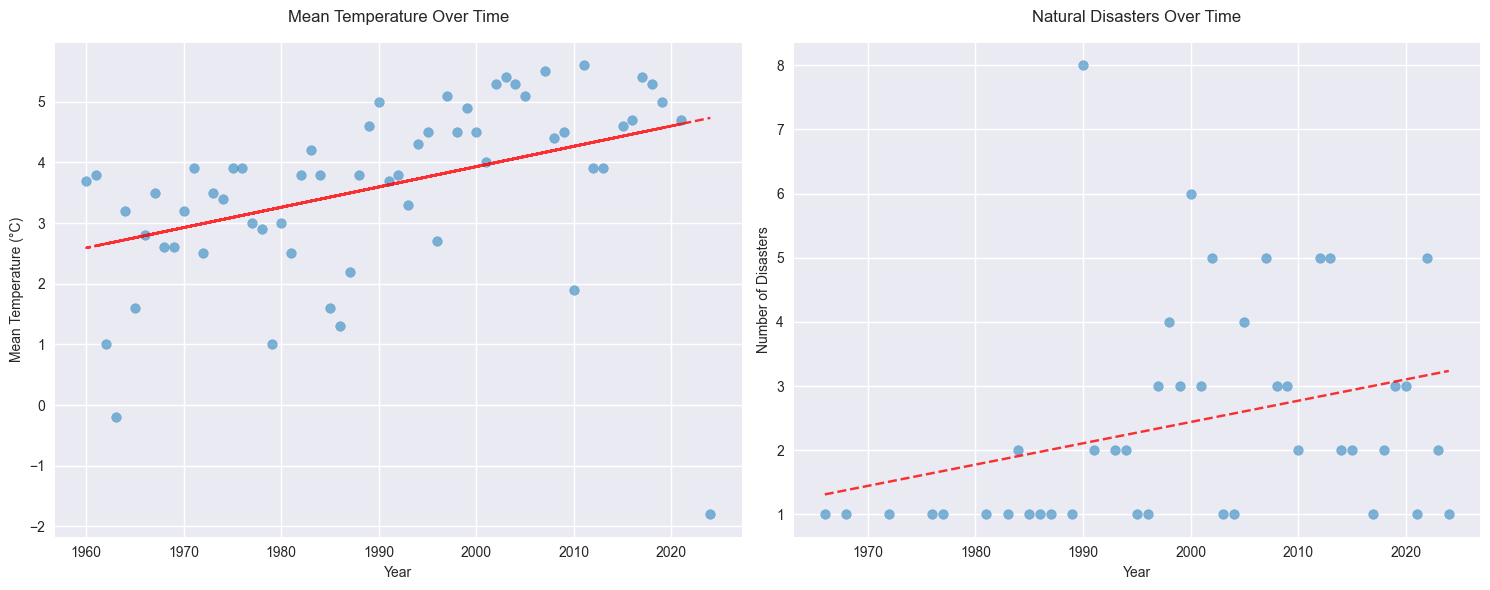

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def process_data(temp_file, disaster_file, start_year=1960):
   # Process temperature data
   with open(temp_file, 'r') as f:
       temp_lines = f.readlines()[11:]
       
   years, temps = [], []
   for line in temp_lines:
       try:
           vals = line.strip().split()
           year = int(vals[-1])
           if year < start_year:
               continue
           temp = float(vals[0])
           years.append(year)
           temps.append(temp)
       except (ValueError, IndexError):
           continue
           
   temp_df = pd.DataFrame({
       'year': years,
       'temperature': temps
   })
   
   # Process disaster data 
   disaster_df = pd.read_csv(disaster_file)
   yearly_disasters = disaster_df.groupby('Start Year').size().reset_index(name='disaster_count')
   disaster_df = yearly_disasters[yearly_disasters['Start Year'] >= start_year]
   disaster_df = disaster_df.rename(columns={'Start Year': 'year'})
   
   return temp_df, disaster_df

def plot_trends(temp_df, disaster_df):
   plt.style.use('seaborn')
   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

   # Temperature trend
   ax1.scatter(temp_df['year'], temp_df['temperature'], c='#2E86C1', alpha=0.6)
   z1 = np.polyfit(temp_df['year'], temp_df['temperature'], 1)
   p1 = np.poly1d(z1)
   ax1.plot(temp_df['year'], p1(temp_df['year']), "r--", alpha=0.8)
   ax1.set_title('Mean Temperature Over Time', fontsize=12, pad=15)
   ax1.set_xlabel('Year', fontsize=10)
   ax1.set_ylabel('Mean Temperature (°C)', fontsize=10)

   # Disasters trend
   ax2.scatter(disaster_df['year'], disaster_df['disaster_count'], c='#2E86C1', alpha=0.6)
   z2 = np.polyfit(disaster_df['year'], disaster_df['disaster_count'], 1)
   p2 = np.poly1d(z2)
   ax2.plot(disaster_df['year'], p2(disaster_df['year']), "r--", alpha=0.8)
   ax2.set_title('Natural Disasters Over Time', fontsize=12, pad=15)
   ax2.set_xlabel('Year', fontsize=10)
   ax2.set_ylabel('Number of Disasters', fontsize=10)

   plt.tight_layout()
   plt.show()

# Usage
temp_df, disaster_df = process_data('UK_mean_temperature_data.txt', 
                                 'UK Natural Disasters Data - EM-DAT Data.csv')
plot_trends(temp_df, disaster_df)


/var/folders/ss/7gdz3mj52njb_7zt7jv9wj2r0000gp/T/ipykernel_49260/3627896817.py:44: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


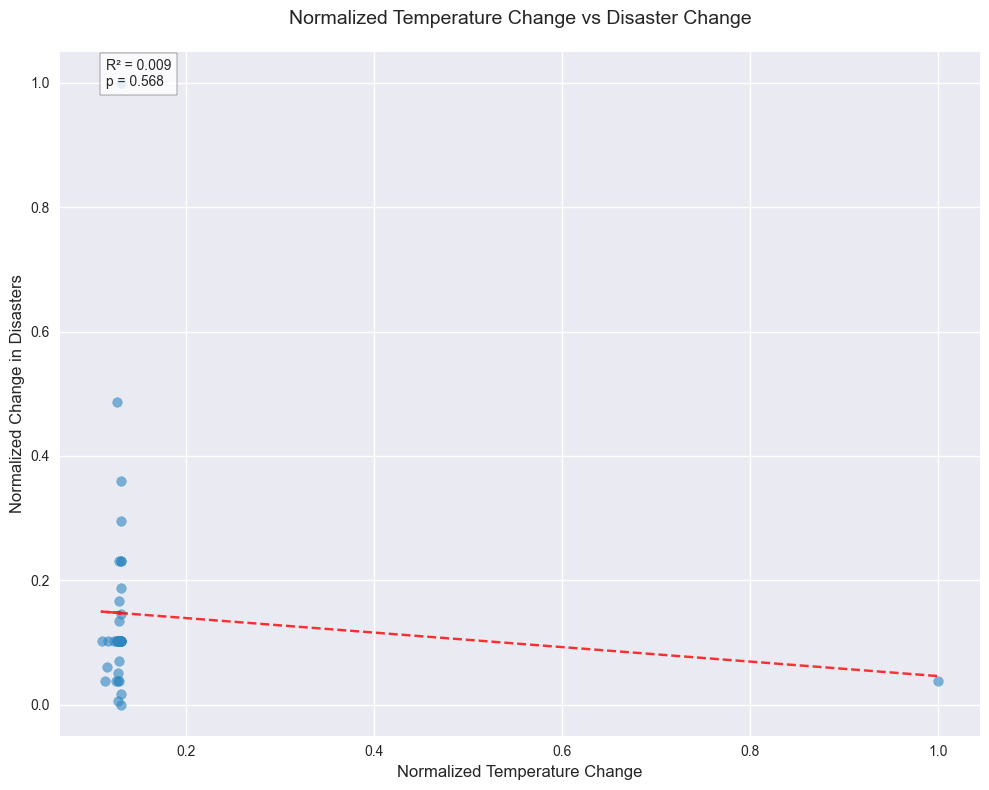

In [16]:
def process_data(temp_file, disaster_file, start_year=1960):
    # Process temperature data
    with open(temp_file, 'r') as f:
        temp_lines = f.readlines()[11:]
        
    years, temps = [], []
    for line in temp_lines:
        try:
            vals = line.strip().split()
            year = int(vals[-1])
            if year < start_year:
                continue
            temp = float(vals[0])
            years.append(year)
            temps.append(temp)
        except (ValueError, IndexError):
            continue
            
    temp_df = pd.DataFrame({
        'year': years,
        'temperature': temps
    })
    temp_df['temp_diff'] = temp_df['temperature'].pct_change()
    
    # Normalize temperature changes
    temp_diff = temp_df['temp_diff']
    temp_df['temp_diff_norm'] = (temp_diff - temp_diff.min()) / (temp_diff.max() - temp_diff.min())
    
    # Process disaster data
    disaster_df = pd.read_csv(disaster_file)
    yearly_disasters = disaster_df.groupby('Start Year').size().reset_index(name='disaster_count')
    disaster_df = yearly_disasters[yearly_disasters['Start Year'] >= start_year]
    disaster_df = disaster_df.rename(columns={'Start Year': 'year'})
    disaster_df['disaster_diff'] = disaster_df['disaster_count'].pct_change()
    
    # Normalize disaster changes
    disaster_diff = disaster_df['disaster_diff']
    disaster_df['disaster_diff_norm'] = (disaster_diff - disaster_diff.min()) / (disaster_diff.max() - disaster_diff.min())
    
    return pd.merge(temp_df, disaster_df, on='year', how='inner')

def plot_relationship(data):
    plt.figure(figsize=(10, 8))
    plt.style.use('seaborn')

    # Use normalized values
    valid_mask = (data['temp_diff_norm'].notna()) & (data['disaster_diff_norm'].notna())
    valid_temp = data.loc[valid_mask, 'temp_diff_norm'] 
    valid_disasters = data.loc[valid_mask, 'disaster_diff_norm']

    plt.scatter(valid_temp, valid_disasters, c='#2E86C1', alpha=0.6)

    z = np.polyfit(valid_temp, valid_disasters, 1)
    p = np.poly1d(z)
    plt.plot(valid_temp, p(valid_temp), "r--", alpha=0.8)

    plt.title('Normalized Temperature Change vs Disaster Change', fontsize=14, pad=20)
    plt.xlabel('Normalized Temperature Change', fontsize=12)
    plt.ylabel('Normalized Change in Disasters', fontsize=12)

    slope, intercept, r_value, p_value, std_err = stats.linregress(valid_temp, valid_disasters)
    plt.text(0.05, 0.95, f'R² = {r_value**2:.3f}\np = {p_value:.3f}',
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

data = process_data('UK_mean_temperature_data.txt', 'UK Natural Disasters Data - EM-DAT Data.csv')
plot_relationship(data)

/var/folders/ss/7gdz3mj52njb_7zt7jv9wj2r0000gp/T/ipykernel_49260/2029343660.py:33: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


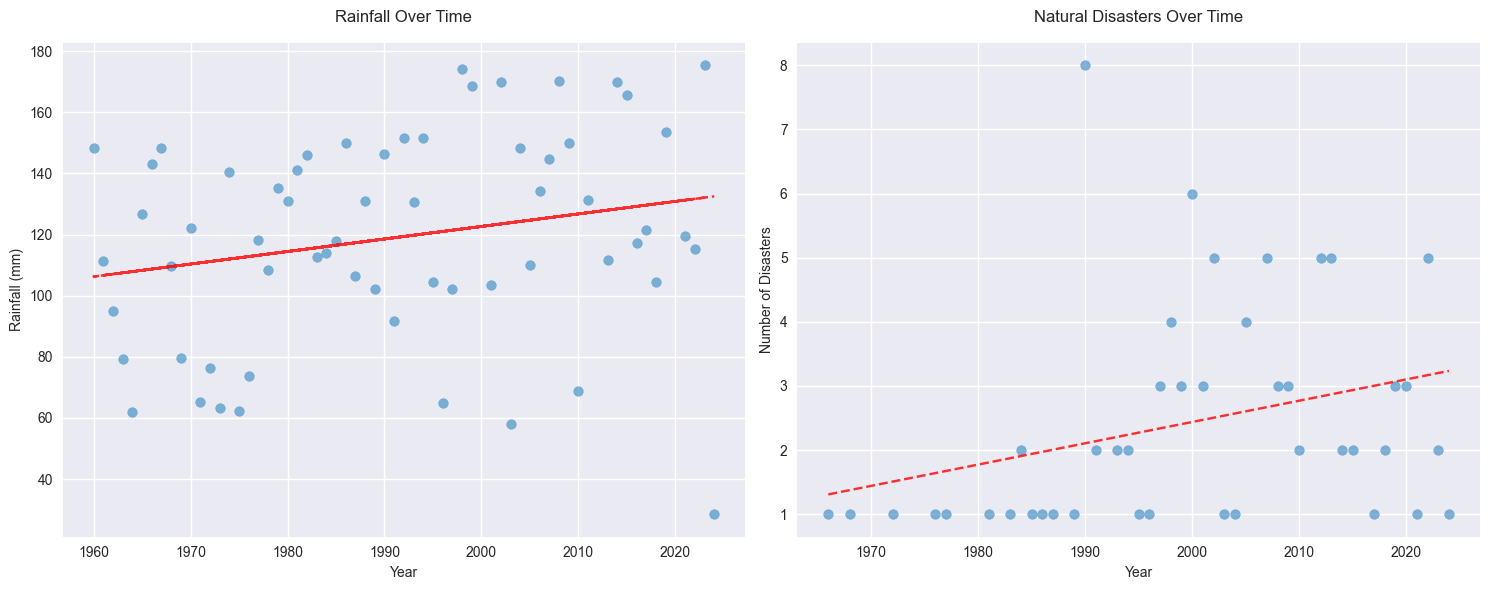

In [22]:
def process_data(rain_file, disaster_file, start_year=1960):
   # Process rainfall data
   with open(rain_file, 'r') as f:
       rain_lines = f.readlines()[11:]  # Skip header lines
       
   years, rainfall = [], []
   for line in rain_lines:
       try:
           vals = line.strip().split()
           year = int(vals[-1])
           if year < start_year:
               continue
           rain = float(vals[0])  # First value is rainfall
           years.append(year)
           rainfall.append(rain)
       except (ValueError, IndexError):
           continue
           
   rain_df = pd.DataFrame({
       'year': years,
       'rainfall': rainfall
   })
   
   # Process disaster data (same as before)
   disaster_df = pd.read_csv(disaster_file)
   yearly_disasters = disaster_df.groupby('Start Year').size().reset_index(name='disaster_count')
   disaster_df = yearly_disasters[yearly_disasters['Start Year'] >= start_year]
   disaster_df = disaster_df.rename(columns={'Start Year': 'year'})
   
   return rain_df, disaster_df

def plot_trends(rain_df, disaster_df):
   plt.style.use('seaborn')
   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

   # Rainfall trend
   ax1.scatter(rain_df['year'], rain_df['rainfall'], c='#2E86C1', alpha=0.6)
   z1 = np.polyfit(rain_df['year'], rain_df['rainfall'], 1)
   p1 = np.poly1d(z1)
   ax1.plot(rain_df['year'], p1(rain_df['year']), "r--", alpha=0.8)
   ax1.set_title('Rainfall Over Time', fontsize=12, pad=15)
   ax1.set_xlabel('Year', fontsize=10)
   ax1.set_ylabel('Rainfall (mm)', fontsize=10)

   # Disasters trend
   ax2.scatter(disaster_df['year'], disaster_df['disaster_count'], c='#2E86C1', alpha=0.6)
   z2 = np.polyfit(disaster_df['year'], disaster_df['disaster_count'], 1)
   p2 = np.poly1d(z2)
   ax2.plot(disaster_df['year'], p2(disaster_df['year']), "r--", alpha=0.8)
   ax2.set_title('Natural Disasters Over Time', fontsize=12, pad=15)
   ax2.set_xlabel('Year', fontsize=10)
   ax2.set_ylabel('Number of Disasters', fontsize=10)

   plt.tight_layout()
   plt.show()

# Usage
rain_df, disaster_df = process_data('UK_rainfall_data.txt', 
                                  'UK Natural Disasters Data - EM-DAT Data.csv')
plot_trends(rain_df, disaster_df)

/var/folders/ss/7gdz3mj52njb_7zt7jv9wj2r0000gp/T/ipykernel_49260/3879520385.py:44: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


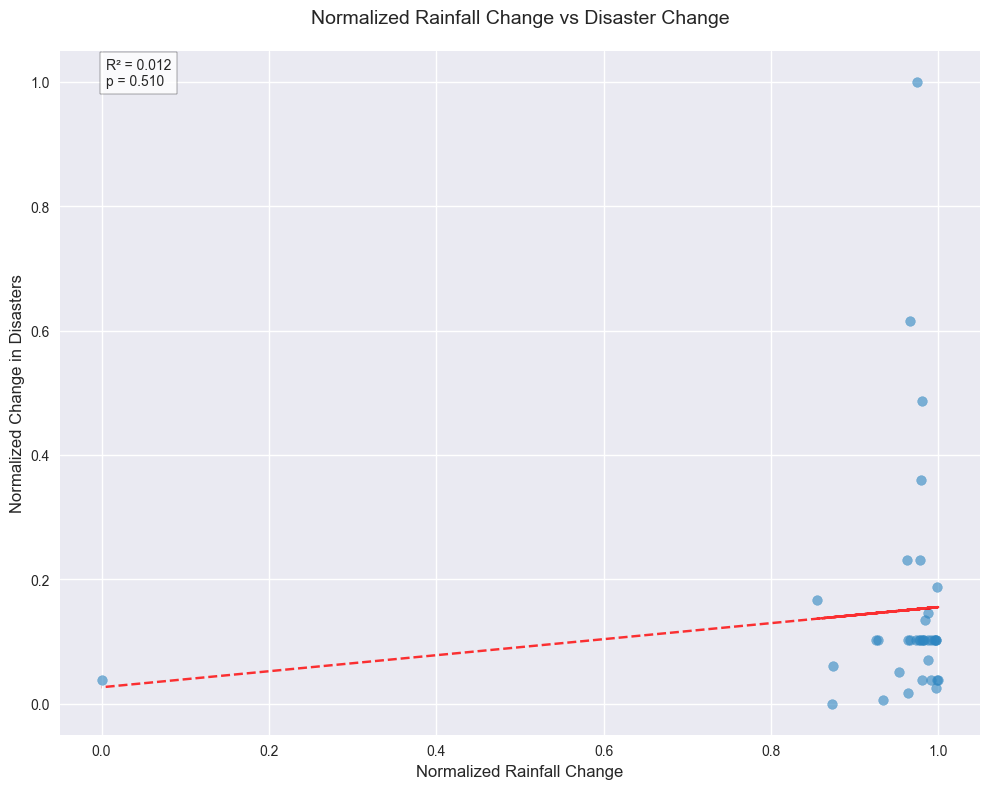

In [23]:
def process_data(rain_file, disaster_file, start_year=1960):
    # Process rainfall data
    with open(rain_file, 'r') as f:
        rain_lines = f.readlines()[11:]
        
    years, rainfall = [], []
    for line in rain_lines:
        try:
            vals = line.strip().split()
            year = int(vals[-1])
            if year < start_year:
                continue
            rain = float(vals[0])
            years.append(year)
            rainfall.append(rain)
        except (ValueError, IndexError):
            continue
            
    rain_df = pd.DataFrame({
        'year': years,
        'rainfall': rainfall
    })
    rain_df['rain_diff'] = rain_df['rainfall'].pct_change()
    
    # Normalize rainfall changes
    rain_diff = rain_df['rain_diff']
    rain_df['rain_diff_norm'] = (rain_diff - rain_diff.min()) / (rain_diff.max() - rain_diff.min())
    
    # Process disaster data
    disaster_df = pd.read_csv(disaster_file)
    yearly_disasters = disaster_df.groupby('Start Year').size().reset_index(name='disaster_count')
    disaster_df = yearly_disasters[yearly_disasters['Start Year'] >= start_year]
    disaster_df = disaster_df.rename(columns={'Start Year': 'year'})
    disaster_df['disaster_diff'] = disaster_df['disaster_count'].pct_change()
    
    # Normalize disaster changes
    disaster_diff = disaster_df['disaster_diff']
    disaster_df['disaster_diff_norm'] = (disaster_diff - disaster_diff.min()) / (disaster_diff.max() - disaster_diff.min())
    
    return pd.merge(rain_df, disaster_df, on='year', how='inner')

def plot_relationship(data):
    plt.figure(figsize=(10, 8))
    plt.style.use('seaborn')

    # Use normalized values
    valid_mask = (data['rain_diff_norm'].notna()) & (data['disaster_diff_norm'].notna())
    valid_rain = data.loc[valid_mask, 'rain_diff_norm'] 
    valid_disasters = data.loc[valid_mask, 'disaster_diff_norm']

    plt.scatter(valid_rain, valid_disasters, c='#2E86C1', alpha=0.6)

    z = np.polyfit(valid_rain, valid_disasters, 1)
    p = np.poly1d(z)
    plt.plot(valid_rain, p(valid_rain), "r--", alpha=0.8)

    plt.title('Normalized Rainfall Change vs Disaster Change', fontsize=14, pad=20)
    plt.xlabel('Normalized Rainfall Change', fontsize=12)
    plt.ylabel('Normalized Change in Disasters', fontsize=12)

    slope, intercept, r_value, p_value, std_err = stats.linregress(valid_rain, valid_disasters)
    plt.text(0.05, 0.95, f'R² = {r_value**2:.3f}\np = {p_value:.3f}',
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

data = process_data('UK_rainfall_data.txt', 'UK Natural Disasters Data - EM-DAT Data.csv')
plot_relationship(data)

/var/folders/ss/7gdz3mj52njb_7zt7jv9wj2r0000gp/T/ipykernel_49260/2301852834.py:56: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


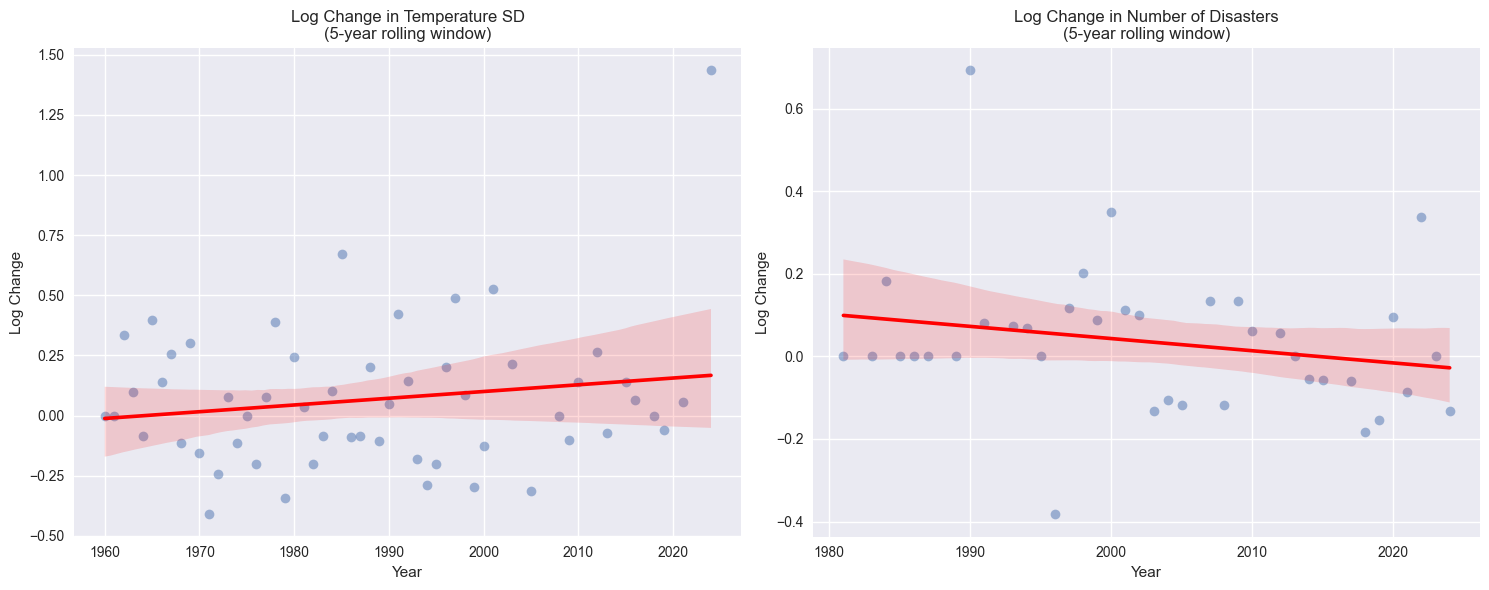

Number of temperature data points: 55
Number of disaster data points: 38

Date ranges:
Temperature data: 1960 - 2024
Disaster data: 1966 - 2024


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Process temperature data with standard deviation
def get_temp_sd(min_temp_file, max_temp_file, start_year=1960, window=5):
    with open(min_temp_file, 'r') as f:
        min_lines = f.readlines()[11:]
    with open(max_temp_file, 'r') as f:
        max_lines = f.readlines()[11:]
    
    temp_data = []
    for min_line, max_line in zip(min_lines, max_lines):
        try:
            year = int(min_line.strip().split()[-1])
            if year < start_year:
                continue
            min_temp = float(min_line.strip().split()[0])
            max_temp = float(max_line.strip().split()[0])
            temp_data.append({
                'year': year,
                'temp': (max_temp + min_temp) / 2  # using mean temperature
            })
        except (ValueError, IndexError):
            continue
    
    df = pd.DataFrame(temp_data)
    
    # Calculate rolling standard deviation
    df['temp_sd'] = df['temp'].rolling(window=window).std()
    df['temp_sd_change'] = df['temp_sd'].pct_change()
    df['log_temp_sd_change'] = np.log(df['temp_sd_change'].abs() + 1) * np.sign(df['temp_sd_change'])
    
    return df

# Process disaster data with rolling counts
def get_disaster_changes(disaster_file, start_year=1960, window=5):
    df = pd.read_csv(disaster_file)
    annual_counts = df.groupby('Start Year').size().reset_index(name='disaster_count')
    annual_counts = annual_counts[annual_counts['Start Year'] >= start_year]
    
    # Calculate rolling mean of disasters
    annual_counts['rolling_disasters'] = annual_counts['disaster_count'].rolling(window=window).mean()
    annual_counts['disaster_change'] = annual_counts['rolling_disasters'].pct_change()
    annual_counts['log_disaster_change'] = np.log(annual_counts['disaster_change'].abs() + 1) * np.sign(annual_counts['disaster_change'])
    
    return annual_counts

# Process data
window_size = 5  # 5-year rolling window
temp_df = get_temp_sd('UK_min_temperature_data.txt', 'UK_max_temperature_data.txt', window=window_size)
disaster_df = get_disaster_changes('UK Natural Disasters Data - EM-DAT Data.csv', window=window_size)

# Create plots
plt.style.use('seaborn')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Temperature SD Changes
sns.regplot(x='year', y='log_temp_sd_change', data=temp_df.dropna(), 
            ax=ax1, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
ax1.set_title(f'Log Change in Temperature SD\n({window_size}-year rolling window)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Log Change')

# Plot 2: Disaster Changes
sns.regplot(x='Start Year', y='log_disaster_change', data=disaster_df.dropna(),
            ax=ax2, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
ax2.set_title(f'Log Change in Number of Disasters\n({window_size}-year rolling window)')
ax2.set_xlabel('Year')
ax2.set_ylabel('Log Change')

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Number of temperature data points: {len(temp_df.dropna())}")
print(f"Number of disaster data points: {len(disaster_df.dropna())}")
print("\nDate ranges:")
print(f"Temperature data: {temp_df['year'].min()} - {temp_df['year'].max()}")
print(f"Disaster data: {disaster_df['Start Year'].min()} - {disaster_df['Start Year'].max()}")

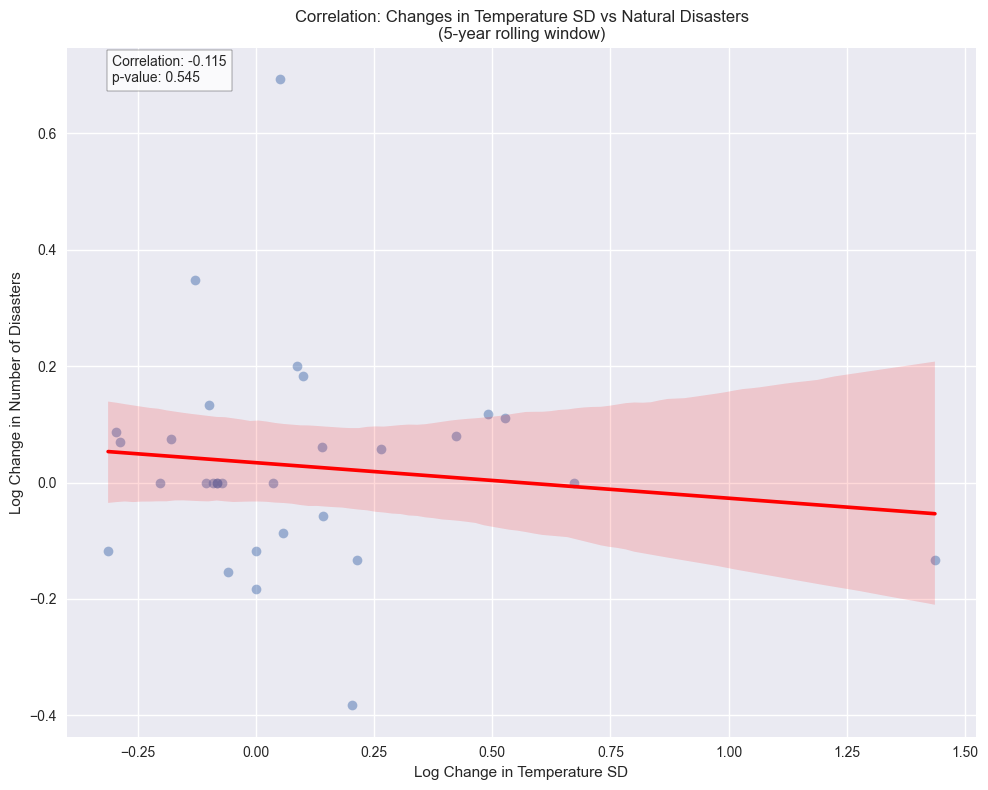

Number of matched data points: 30
Date range: 1981 - 2024


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def get_temp_sd(min_temp_file, max_temp_file, start_year=1960, window=5):
    with open(min_temp_file, 'r') as f:
        min_lines = f.readlines()[11:]
    with open(max_temp_file, 'r') as f:
        max_lines = f.readlines()[11:]
    
    temp_data = []
    for min_line, max_line in zip(min_lines, max_lines):
        try:
            year = int(min_line.strip().split()[-1])
            if year < start_year:
                continue
            min_temp = float(min_line.strip().split()[0])
            max_temp = float(max_line.strip().split()[0])
            temp_data.append({
                'year': year,
                'temp': (max_temp + min_temp) / 2
            })
        except (ValueError, IndexError):
            continue
    
    df = pd.DataFrame(temp_data)
    df['temp_sd'] = df['temp'].rolling(window=window).std()
    df['temp_sd_change'] = df['temp_sd'].pct_change()
    df['log_temp_sd_change'] = np.log(df['temp_sd_change'].abs() + 1) * np.sign(df['temp_sd_change'])
    return df

def get_disaster_changes(disaster_file, start_year=1960, window=5):
    df = pd.read_csv(disaster_file)
    annual_counts = df.groupby('Start Year').size().reset_index(name='disaster_count')
    annual_counts = annual_counts[annual_counts['Start Year'] >= start_year]
    
    annual_counts['rolling_disasters'] = annual_counts['disaster_count'].rolling(window=window).mean()
    annual_counts['disaster_change'] = annual_counts['rolling_disasters'].pct_change()
    annual_counts['log_disaster_change'] = np.log(annual_counts['disaster_change'].abs() + 1) * np.sign(annual_counts['disaster_change'])
    return annual_counts

# Process data
window_size = 5
temp_df = get_temp_sd('UK_min_temperature_data.txt', 'UK_max_temperature_data.txt', window=window_size)
disaster_df = get_disaster_changes('UK Natural Disasters Data - EM-DAT Data.csv', window=window_size)

# Merge the datasets on year
merged_df = pd.merge(temp_df, disaster_df,
                    left_on='year',
                    right_on='Start Year',
                    how='inner')
merged_df = merged_df.dropna()

# Calculate correlation
correlation = stats.pearsonr(merged_df['log_temp_sd_change'], 
                           merged_df['log_disaster_change'])

# Create correlation plot
plt.figure(figsize=(10, 8))
sns.regplot(x='log_temp_sd_change', 
            y='log_disaster_change', 
            data=merged_df,
            scatter_kws={'alpha':0.5},
            line_kws={'color': 'red'})

plt.title('Correlation: Changes in Temperature SD vs Natural Disasters\n(5-year rolling window)')
plt.xlabel('Log Change in Temperature SD')
plt.ylabel('Log Change in Number of Disasters')

# Add correlation coefficient and p-value to plot
plt.text(0.05, 0.95, 
         f'Correlation: {correlation[0]:.3f}\np-value: {correlation[1]:.3f}', 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print some statistics about the merged dataset
print(f"Number of matched data points: {len(merged_df)}")
print(f"Date range: {merged_df['year'].min()} - {merged_df['year'].max()}")

In [1]:
import pandas as pd
import numpy as np

def create_clean_summary(min_temp_file, max_temp_file, disaster_file, period_length=5):
    # Read temperature data
    with open(min_temp_file, 'r') as f:
        min_lines = f.readlines()[11:]
    with open(max_temp_file, 'r') as f:
        max_lines = f.readlines()[11:]
    
    # Process temperature data
    temp_data = []
    for min_line, max_line in zip(min_lines, max_lines):
        try:
            year = int(min_line.strip().split()[-1])
            if year < 1960:  # Starting from 1960
                continue
            min_temp = float(min_line.strip().split()[0])
            max_temp = float(max_line.strip().split()[0])
            temp_data.append({
                'year': year,
                'temp_range': max_temp - min_temp
            })
        except (ValueError, IndexError):
            continue
    
    temp_df = pd.DataFrame(temp_data)
    
    # Process disaster data
    disaster_df = pd.read_csv(disaster_file)
    disaster_counts = disaster_df.groupby('Start Year').size().reset_index(name='count')
    
    # Create periods
    temp_df['period'] = pd.cut(temp_df['year'], 
                              bins=range(1960, 2025, period_length),
                              labels=[f"{i}-{i+period_length-1}" 
                                    for i in range(1960, 2020, period_length)])
    
    disaster_counts['period'] = pd.cut(disaster_counts['Start Year'], 
                                     bins=range(1960, 2025, period_length),
                                     labels=[f"{i}-{i+period_length-1}" 
                                           for i in range(1960, 2020, period_length)])
    
    # Calculate summaries
    temp_summary = temp_df.groupby('period')['temp_range'].agg(['mean', 'std']).round(3)
    temp_summary.columns = ['Mean Temp Range', 'Temp SD']
    
    disaster_summary = disaster_counts.groupby('period')['count'].agg(['mean', 'count']).round(3)
    disaster_summary.columns = ['Avg Annual Disasters', 'Years with Data']
    
    # Combine summaries
    summary = pd.concat([temp_summary, disaster_summary], axis=1)
    return summary

# Create and display table
summary_table = create_clean_summary('UK_min_temperature_data.txt', 
                                   'UK_max_temperature_data.txt',
                                   'UK Natural Disasters Data - EM-DAT Data.csv')
print("Period Summary (5-year periods):")
print("\nTemperature and Disaster Metrics by Period:")
print(summary_table)

/var/folders/ss/7gdz3mj52njb_7zt7jv9wj2r0000gp/T/ipykernel_65033/1295444823.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_summary = temp_df.groupby('period')['temp_range'].agg(['mean', 'std']).round(3)
/var/folders/ss/7gdz3mj52njb_7zt7jv9wj2r0000gp/T/ipykernel_65033/1295444823.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disaster_summary = disaster_counts.groupby('period')['count'].agg(['mean', 'count']).round(3)


Period Summary (5-year periods):

Temperature and Disaster Metrics by Period:
           Mean Temp Range  Temp SD  Avg Annual Disasters  Years with Data
period                                                                    
1960-1964            5.180    0.084                   NaN                0
1965-1969            5.240    0.114                  1.00                2
1970-1974            5.320    0.084                  1.00                1
1975-1979            5.320    0.084                  1.00                2
1980-1984            5.360    0.055                  1.25                4
1985-1989            5.440    0.152                  2.75                4
1990-1994            5.400    0.100                  1.75                4
1995-1999            5.460    0.167                  3.40                5
2000-2004            5.440    0.114                  2.80                5
2005-2009            5.425    0.171                  3.25                4
2010-2014            5

/var/folders/ss/7gdz3mj52njb_7zt7jv9wj2r0000gp/T/ipykernel_65033/306309862.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disaster_counts.values, y=disaster_counts.index, ax=ax1, palette='viridis')
/var/folders/ss/7gdz3mj52njb_7zt7jv9wj2r0000gp/T/ipykernel_65033/306309862.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=death_counts.values, y=death_counts.index, ax=ax2, palette='viridis')


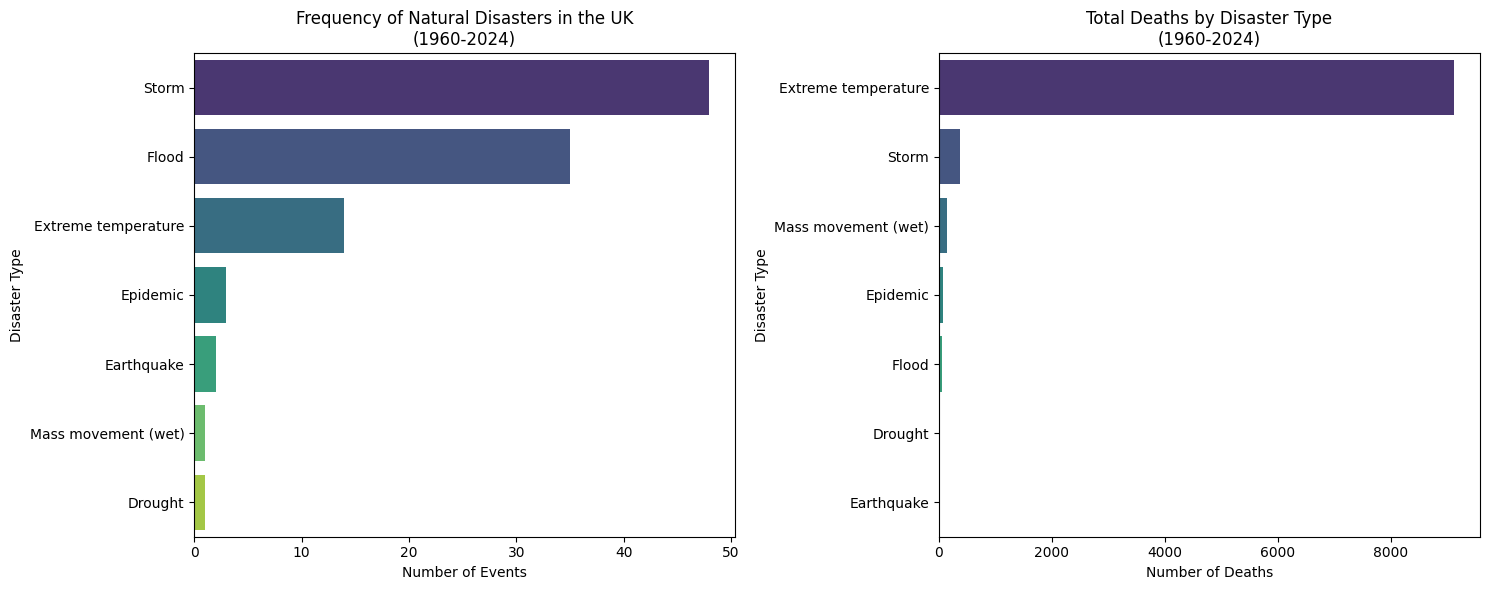


Disaster Frequency Summary:
Disaster Type
Storm                  48
Flood                  35
Extreme temperature    14
Epidemic                3
Earthquake              2
Mass movement (wet)     1
Drought                 1
Name: count, dtype: int64

Casualties Summary:
Disaster Type
Extreme temperature    9121.0
Storm                   371.0
Mass movement (wet)     140.0
Epidemic                 71.0
Flood                    60.0
Drought                   0.0
Earthquake                0.0
Name: Total Deaths, dtype: float64


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read disaster data
disaster_df = pd.read_csv('UK Natural Disasters Data - EM-DAT Data.csv')

# Count disasters by type
disaster_counts = disaster_df['Disaster Type'].value_counts()

# Calculate total deaths by disaster type
death_counts = disaster_df.groupby('Disaster Type')['Total Deaths'].sum().sort_values(ascending=False)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Disaster Frequency
sns.barplot(x=disaster_counts.values, y=disaster_counts.index, ax=ax1, palette='viridis')
ax1.set_title('Frequency of Natural Disasters in the UK\n(1960-2024)')
ax1.set_xlabel('Number of Events')
ax1.set_ylabel('Disaster Type')

# Plot 2: Casualties
sns.barplot(x=death_counts.values, y=death_counts.index, ax=ax2, palette='viridis')
ax2.set_title('Total Deaths by Disaster Type\n(1960-2024)')
ax2.set_xlabel('Number of Deaths')
ax2.set_ylabel('Disaster Type')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nDisaster Frequency Summary:")
print(disaster_counts)
print("\nCasualties Summary:")
print(death_counts)

Correlation results for different lags:
   lag  correlation  p_value
0    0        0.019    0.913
1    1       -0.058    0.737
2    2       -0.147    0.378
3    3       -0.237    0.152

Best lag: 3.0 years


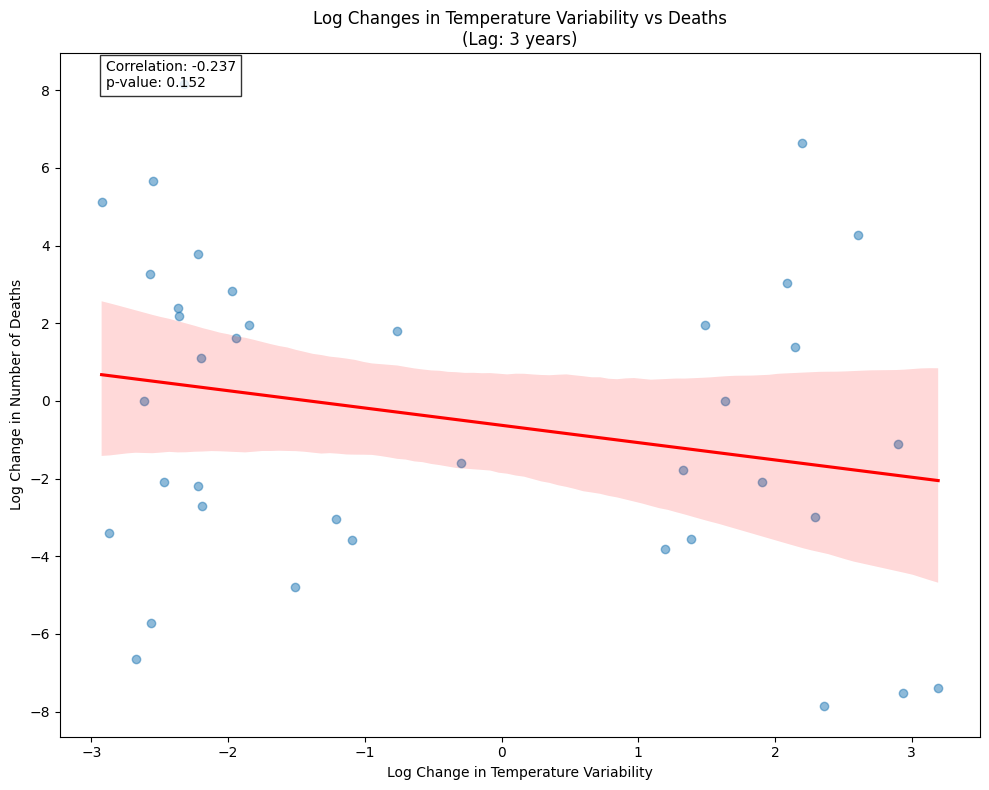


Detailed data for best lag period:
 year  temp_variability  log_temp_var_change  Total Deaths  log_death_change
 1968            30.088               -1.510          20.0            -4.796
 1972            31.415               -1.208           0.0            -3.045
 1976            30.647               -2.612           0.0             0.000
 1977            41.998               -1.846           6.0             1.946
 1981            45.427                1.488          12.0             1.946
 1983            45.540                1.903           5.0            -2.079
 1984            35.774               -2.222          48.0             3.784
 1985            28.513               -2.188          34.0            -2.708
 1986            37.464                1.386           0.0            -3.555
 1987            47.335                2.087          20.0             3.045
 1989            27.278               -2.468          13.0            -2.079
 1990            43.999                2

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def log_transform_with_sign(x):
    return np.sign(x) * np.log1p(np.abs(x))

def get_annual_temp_var(min_temp_file, max_temp_file, start_year=1960):
    with open(min_temp_file, 'r') as f:
        min_lines = f.readlines()[11:]
    with open(max_temp_file, 'r') as f:
        max_lines = f.readlines()[11:]
    
    annual_data = []
    
    for min_line, max_line in zip(min_lines, max_lines):
        try:
            year = int(min_line.strip().split()[-1])
            if year < start_year:
                continue
                
            min_temps = [float(x) for x in min_line.strip().split()[:-1]]
            max_temps = [float(x) for x in max_line.strip().split()[:-1]]
            monthly_ranges = [max_t - min_t for max_t, min_t in zip(max_temps, min_temps)]
            variability = np.std(monthly_ranges)
            
            annual_data.append({
                'year': year,
                'temp_variability': variability
            })
            
        except (ValueError, IndexError):
            continue
    
    df = pd.DataFrame(annual_data)
    df['temp_var_change'] = df['temp_variability'].diff()
    # Log transform temperature variability changes
    df['log_temp_var_change'] = log_transform_with_sign(df['temp_var_change'])
    return df

# Process data
temp_df = get_annual_temp_var('UK_min_temperature_data.txt', 'UK_max_temperature_data.txt')
disaster_df = pd.read_csv('UK Natural Disasters Data - EM-DAT Data.csv')

# Get annual deaths
annual_deaths = disaster_df.groupby('Start Year')['Total Deaths'].sum().reset_index()
annual_deaths = annual_deaths[annual_deaths['Start Year'] >= 1960]
annual_deaths['death_change'] = annual_deaths['Total Deaths'].diff()
annual_deaths['log_death_change'] = log_transform_with_sign(annual_deaths['death_change'])

# Test different lags and store correlations
max_lag = 3
correlations = []
for lag in range(max_lag + 1):
    # Create lagged temp data
    temp_lagged = temp_df.copy()
    temp_lagged['year'] = temp_lagged['year'] + lag
    
    # Merge with death data
    merged = pd.merge(temp_lagged, annual_deaths, 
                     left_on='year', 
                     right_on='Start Year',
                     how='inner')
    merged = merged.replace([np.inf, -np.inf], np.nan).dropna()
    
    # Calculate correlation
    corr = stats.pearsonr(merged['log_temp_var_change'], 
                         merged['log_death_change'])
    correlations.append({
        'lag': lag,
        'correlation': corr[0],
        'p_value': corr[1]
    })

# Find best lag
correlations_df = pd.DataFrame(correlations)
best_lag = correlations_df.loc[correlations_df['p_value'].idxmin()]

print("Correlation results for different lags:")
print(correlations_df.round(3))
print(f"\nBest lag: {best_lag['lag']} years")

# Plot with best lag
temp_lagged = temp_df.copy()
temp_lagged['year'] = temp_lagged['year'] + int(best_lag['lag'])
merged_best = pd.merge(temp_lagged, annual_deaths, 
                      left_on='year', 
                      right_on='Start Year',
                      how='inner')
merged_best = merged_best.replace([np.inf, -np.inf], np.nan).dropna()

# Create plot
plt.figure(figsize=(10, 8))
sns.regplot(x='log_temp_var_change', 
            y='log_death_change', 
            data=merged_best,
            scatter_kws={'alpha':0.5},
            line_kws={'color': 'red'})

plt.title(f'Log Changes in Temperature Variability vs Deaths\n(Lag: {int(best_lag["lag"])} years)')
plt.xlabel('Log Change in Temperature Variability')
plt.ylabel('Log Change in Number of Deaths')

plt.text(0.05, 0.95, 
         f'Correlation: {best_lag["correlation"]:.3f}\np-value: {best_lag["p_value"]:.3f}', 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Show detailed data for best lag
summary = merged_best[['year', 'temp_variability', 'log_temp_var_change', 
                      'Total Deaths', 'log_death_change']].sort_values('year')
print("\nDetailed data for best lag period:")
print(summary.round(3).to_string(index=False))

Correlation results for different lags:
   lag  correlation  p_value  n_observations
0    0        0.015    0.920              51
1    1       -0.231    0.099              52
2    2        0.215    0.122              53
3    3       -0.156    0.261              54
4    4        0.015    0.912              54
5    5        0.024    0.861              54

Best lag: 1.0 years


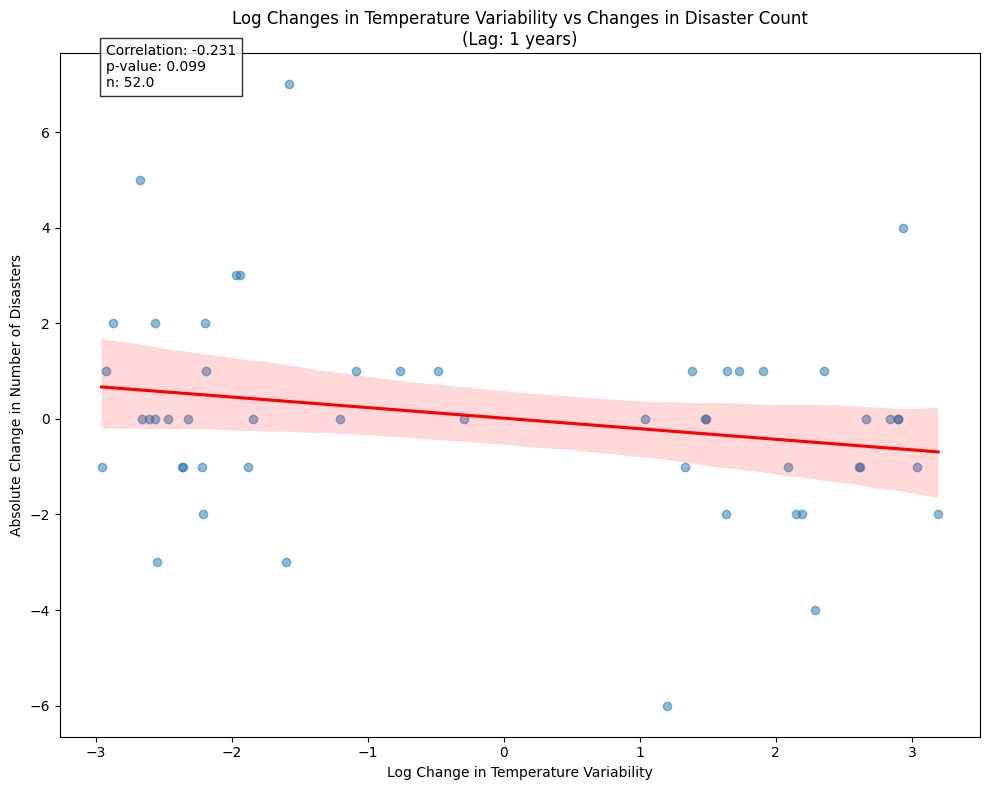


Summary for best lag period:
 year  temp_variability  log_temp_var_change  disaster_count  disaster_change
 1967            39.836                2.616             0.0             -1.0
 1968            36.430               -0.485             1.0              1.0
 1969            50.479                3.036             0.0             -1.0
 1970            31.415               -1.208             0.0              0.0
 1971            43.274                2.662             0.0              0.0
 1972            34.820                1.641             1.0              1.0
 1973            30.229               -1.879             0.0             -1.0
 1974            30.647               -2.612             0.0              0.0
 1975            41.998               -1.846             0.0              0.0
 1976            37.054                1.725             1.0              1.0
 1977            32.439               -2.665             1.0              0.0
 1978            27.150           

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def log_transform_with_sign(x):
    return np.sign(x) * np.log1p(np.abs(x))

def get_annual_temp_var(min_temp_file, max_temp_file, start_year=1960):
    with open(min_temp_file, 'r') as f:
        min_lines = f.readlines()[11:]
    with open(max_temp_file, 'r') as f:
        max_lines = f.readlines()[11:]
    
    annual_data = []
    for min_line, max_line in zip(min_lines, max_lines):
        try:
            year = int(min_line.strip().split()[-1])
            if year < start_year:
                continue
                
            min_temps = [float(x) for x in min_line.strip().split()[:-1]]
            max_temps = [float(x) for x in max_line.strip().split()[:-1]]
            monthly_ranges = [max_t - min_t for max_t, min_t in zip(max_temps, min_temps)]
            variability = np.std(monthly_ranges)
            
            annual_data.append({
                'year': year,
                'temp_variability': variability
            })
        except (ValueError, IndexError):
            continue
    
    df = pd.DataFrame(annual_data)
    df['temp_var_change'] = df['temp_variability'].diff()
    df['log_temp_var_change'] = log_transform_with_sign(df['temp_var_change'])
    return df

# Process data
temp_df = get_annual_temp_var('UK_min_temperature_data.txt', 'UK_max_temperature_data.txt')
disaster_df = pd.read_csv('UK Natural Disasters Data - EM-DAT Data.csv')

# Get annual disaster counts
annual_disasters = disaster_df.groupby('Start Year').size().reset_index(name='disaster_count')
annual_disasters = annual_disasters[annual_disasters['Start Year'] >= 1960]

# Create full year range and fill missing years with zero
year_range = pd.DataFrame({'Start Year': range(annual_disasters['Start Year'].min(),
                                             annual_disasters['Start Year'].max() + 1)})
annual_disasters = pd.merge(year_range, annual_disasters, on='Start Year', how='left')
annual_disasters['disaster_count'] = annual_disasters['disaster_count'].fillna(0)
annual_disasters['disaster_change'] = annual_disasters['disaster_count'].diff()

# Test different lags
max_lag = 5
correlations = []
for lag in range(max_lag + 1):
    # Create lagged temp data
    temp_lagged = temp_df.copy()
    temp_lagged['year'] = temp_lagged['year'] + lag
    
    # Merge with disaster data
    merged = pd.merge(temp_lagged, annual_disasters, 
                     left_on='year', 
                     right_on='Start Year',
                     how='inner')
    merged = merged.replace([np.inf, -np.inf], np.nan).dropna()
    
    # Calculate correlation
    corr = stats.pearsonr(merged['log_temp_var_change'], 
                         merged['disaster_change'])
    correlations.append({
        'lag': lag,
        'correlation': corr[0],
        'p_value': corr[1],
        'n_observations': len(merged)
    })

# Find best lag
correlations_df = pd.DataFrame(correlations)
best_lag = correlations_df.loc[correlations_df['p_value'].idxmin()]

print("Correlation results for different lags:")
print(correlations_df.round(3))
print(f"\nBest lag: {best_lag['lag']} years")

# Plot with best lag
temp_lagged = temp_df.copy()
temp_lagged['year'] = temp_lagged['year'] + int(best_lag['lag'])
merged_best = pd.merge(temp_lagged, annual_disasters, 
                      left_on='year', 
                      right_on='Start Year',
                      how='inner')
merged_best = merged_best.replace([np.inf, -np.inf], np.nan).dropna()

# Create plot
plt.figure(figsize=(10, 8))
sns.regplot(x='log_temp_var_change', 
            y='disaster_change', 
            data=merged_best,
            scatter_kws={'alpha':0.5},
            line_kws={'color': 'red'})

plt.title(f'Log Changes in Temperature Variability vs Changes in Disaster Count\n(Lag: {int(best_lag["lag"])} years)')
plt.xlabel('Log Change in Temperature Variability')
plt.ylabel('Absolute Change in Number of Disasters')

plt.text(0.05, 0.95, 
         f'Correlation: {best_lag["correlation"]:.3f}\np-value: {best_lag["p_value"]:.3f}\nn: {best_lag["n_observations"]}', 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Show summary table for best lag period
summary = merged_best[['year', 'temp_variability', 'log_temp_var_change', 
                      'disaster_count', 'disaster_change']].sort_values('year')
print("\nSummary for best lag period:")
print(summary.round(3).to_string(index=False))

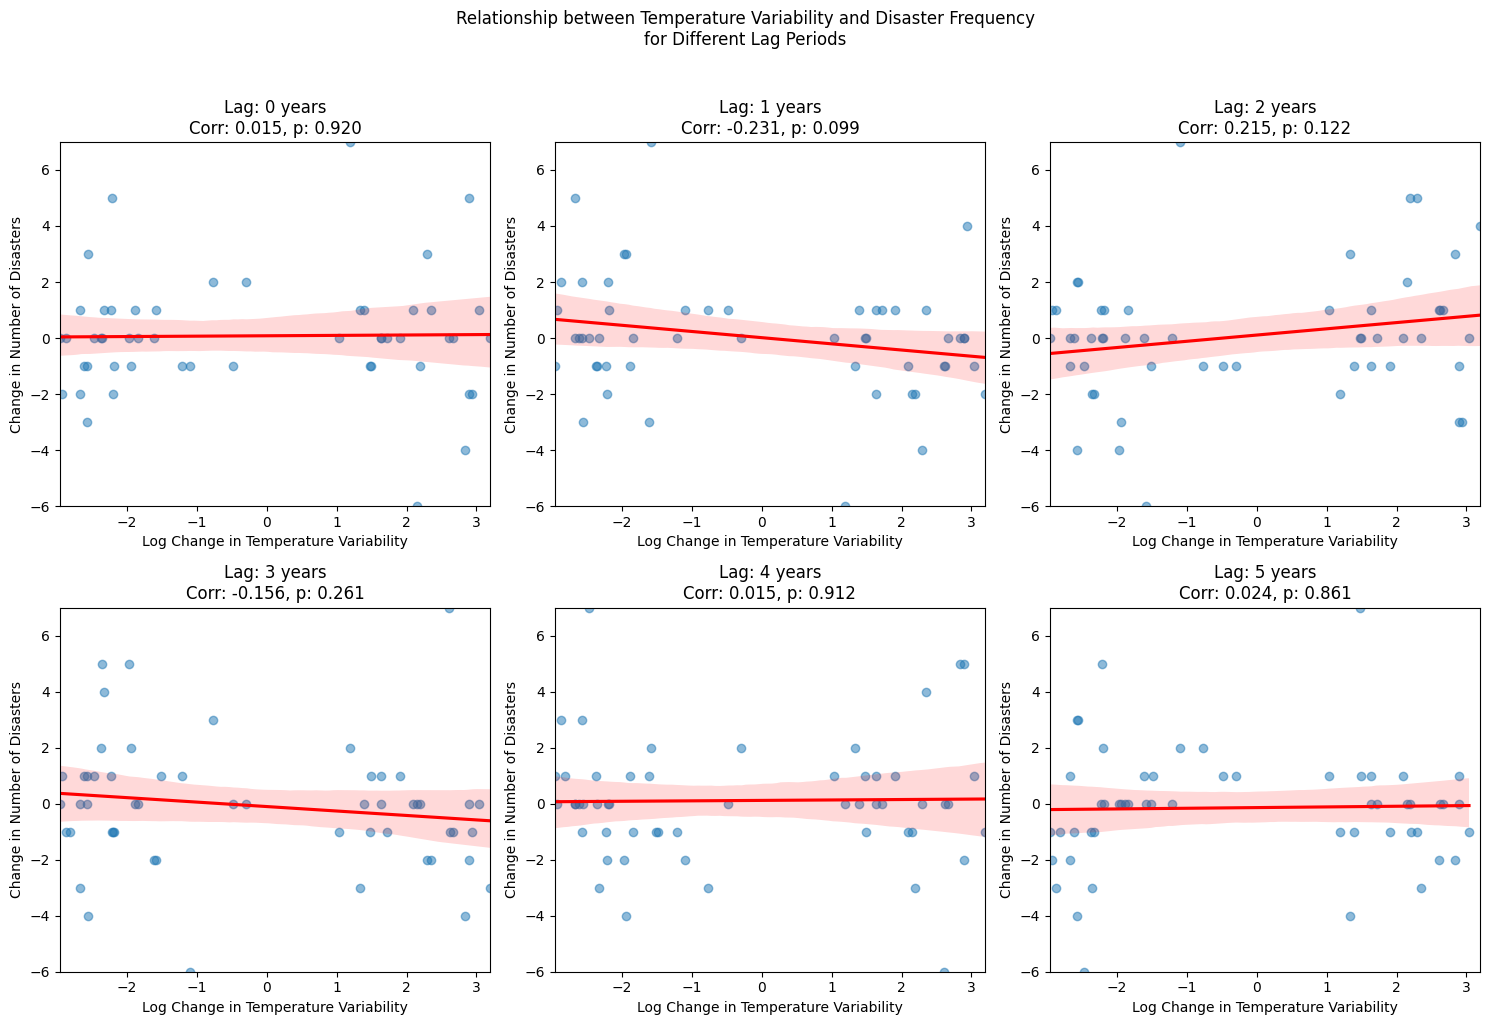


Correlation summary for different lags:
Lag 0 years: correlation = 0.015, p-value = 0.920, n = 51
Lag 1 years: correlation = -0.231, p-value = 0.099, n = 52
Lag 2 years: correlation = 0.215, p-value = 0.122, n = 53
Lag 3 years: correlation = -0.156, p-value = 0.261, n = 54
Lag 4 years: correlation = 0.015, p-value = 0.912, n = 54
Lag 5 years: correlation = 0.024, p-value = 0.861, n = 54


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def log_transform_with_sign(x):
    return np.sign(x) * np.log1p(np.abs(x))

def get_annual_temp_var(min_temp_file, max_temp_file, start_year=1960):
    with open(min_temp_file, 'r') as f:
        min_lines = f.readlines()[11:]
    with open(max_temp_file, 'r') as f:
        max_lines = f.readlines()[11:]
    
    annual_data = []
    for min_line, max_line in zip(min_lines, max_lines):
        try:
            year = int(min_line.strip().split()[-1])
            if year < start_year:
                continue
                
            min_temps = [float(x) for x in min_line.strip().split()[:-1]]
            max_temps = [float(x) for x in max_line.strip().split()[:-1]]
            monthly_ranges = [max_t - min_t for max_t, min_t in zip(max_temps, min_temps)]
            variability = np.std(monthly_ranges)
            
            annual_data.append({
                'year': year,
                'temp_variability': variability
            })
        except (ValueError, IndexError):
            continue
    
    df = pd.DataFrame(annual_data)
    df['temp_var_change'] = df['temp_variability'].diff()
    df['log_temp_var_change'] = log_transform_with_sign(df['temp_var_change'])
    return df

# Process data
temp_df = get_annual_temp_var('UK_min_temperature_data.txt', 'UK_max_temperature_data.txt')
disaster_df = pd.read_csv('UK Natural Disasters Data - EM-DAT Data.csv')

# Get annual disaster counts with full year range
annual_disasters = disaster_df.groupby('Start Year').size().reset_index(name='disaster_count')
annual_disasters = annual_disasters[annual_disasters['Start Year'] >= 1960]
year_range = pd.DataFrame({'Start Year': range(annual_disasters['Start Year'].min(),
                                             annual_disasters['Start Year'].max() + 1)})
annual_disasters = pd.merge(year_range, annual_disasters, on='Start Year', how='left')
annual_disasters['disaster_count'] = annual_disasters['disaster_count'].fillna(0)
annual_disasters['disaster_change'] = annual_disasters['disaster_count'].diff()

# Create subplots for different lags
max_lag = 5
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# Store y-limits to standardize plots
all_merged_data = []

# First pass to get data ranges
for lag in range(max_lag + 1):
    temp_lagged = temp_df.copy()
    temp_lagged['year'] = temp_lagged['year'] + lag
    merged = pd.merge(temp_lagged, annual_disasters, 
                     left_on='year', 
                     right_on='Start Year',
                     how='inner')
    merged = merged.replace([np.inf, -np.inf], np.nan).dropna()
    all_merged_data.append(merged)

# Get common limits
x_min = min([df['log_temp_var_change'].min() for df in all_merged_data])
x_max = max([df['log_temp_var_change'].max() for df in all_merged_data])
y_min = min([df['disaster_change'].min() for df in all_merged_data])
y_max = max([df['disaster_change'].max() for df in all_merged_data])

# Create plots
for lag in range(max_lag + 1):
    merged = all_merged_data[lag]
    
    # Calculate correlation
    corr = stats.pearsonr(merged['log_temp_var_change'], 
                         merged['disaster_change'])
    
    # Create plot
    sns.regplot(x='log_temp_var_change', 
                y='disaster_change', 
                data=merged,
                scatter_kws={'alpha':0.5},
                line_kws={'color': 'red'},
                ax=axes[lag])
    
    axes[lag].set_title(f'Lag: {lag} years\nCorr: {corr[0]:.3f}, p: {corr[1]:.3f}')
    axes[lag].set_xlabel('Log Change in Temperature Variability')
    axes[lag].set_ylabel('Change in Number of Disasters')
    
    # Set consistent limits
    axes[lag].set_xlim(x_min, x_max)
    axes[lag].set_ylim(y_min, y_max)

plt.suptitle('Relationship between Temperature Variability and Disaster Frequency\nfor Different Lag Periods', 
            y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

# Print summary of correlations
print("\nCorrelation summary for different lags:")
for lag in range(max_lag + 1):
    corr = stats.pearsonr(all_merged_data[lag]['log_temp_var_change'],
                         all_merged_data[lag]['disaster_change'])
    print(f"Lag {lag} years: correlation = {corr[0]:.3f}, p-value = {corr[1]:.3f}, n = {len(all_merged_data[lag])}")

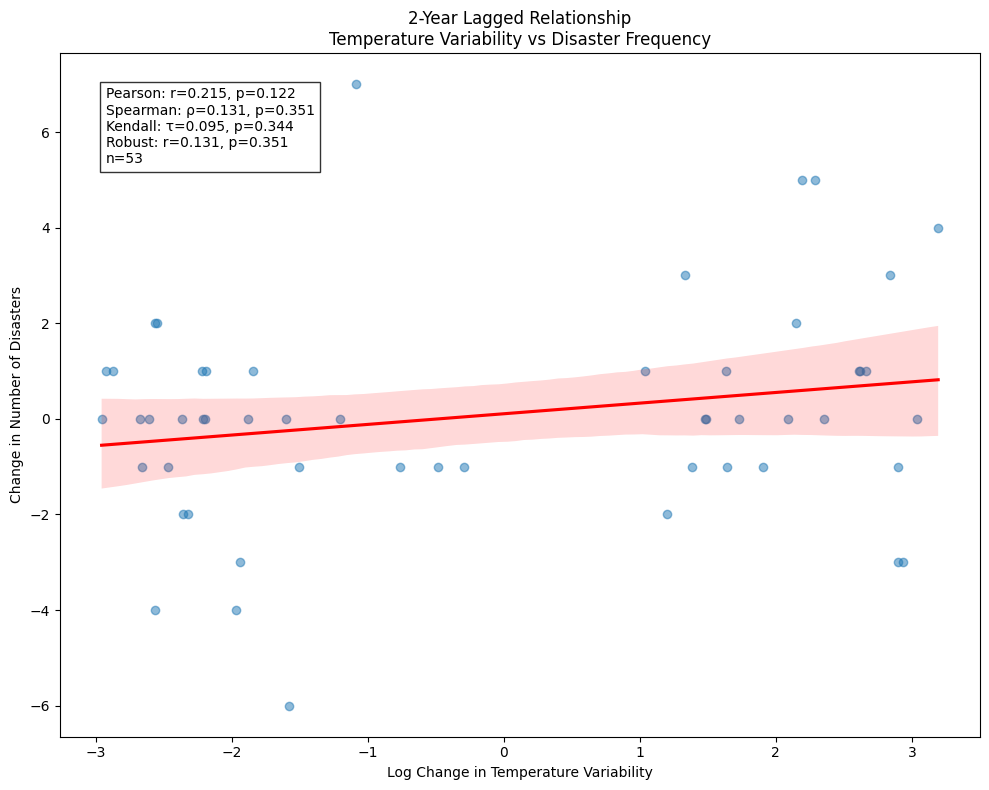


Detailed Correlation Results (2-year lag):

1. Pearson Correlation (parametric):
r = 0.215, p-value = 0.122

2. Spearman Rank Correlation (non-parametric):
ρ = 0.131, p-value = 0.351

3. Kendall's Tau (non-parametric):
τ = 0.095, p-value = 0.344

4. Robust Correlation (ranked):
r = 0.131, p-value = 0.351

Number of observations: 53


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr, kendalltau
from sklearn.preprocessing import StandardScaler

def log_transform_with_sign(x):
    return np.sign(x) * np.log1p(np.abs(x))

# Get temperature data
def get_annual_temp_var(min_temp_file, max_temp_file, start_year=1960):
    with open(min_temp_file, 'r') as f:
        min_lines = f.readlines()[11:]
    with open(max_temp_file, 'r') as f:
        max_lines = f.readlines()[11:]
    
    annual_data = []
    for min_line, max_line in zip(min_lines, max_lines):
        try:
            year = int(min_line.strip().split()[-1])
            if year < start_year:
                continue
                
            min_temps = [float(x) for x in min_line.strip().split()[:-1]]
            max_temps = [float(x) for x in max_line.strip().split()[:-1]]
            monthly_ranges = [max_t - min_t for max_t, min_t in zip(max_temps, min_temps)]
            variability = np.std(monthly_ranges)
            
            annual_data.append({
                'year': year,
                'temp_variability': variability
            })
        except (ValueError, IndexError):
            continue
    
    df = pd.DataFrame(annual_data)
    df['temp_var_change'] = df['temp_variability'].diff()
    df['log_temp_var_change'] = log_transform_with_sign(df['temp_var_change'])
    return df

# Process data
temp_df = get_annual_temp_var('UK_min_temperature_data.txt', 'UK_max_temperature_data.txt')
disaster_df = pd.read_csv('UK Natural Disasters Data - EM-DAT Data.csv')

# Get annual disaster counts
annual_disasters = disaster_df.groupby('Start Year').size().reset_index(name='disaster_count')
annual_disasters = annual_disasters[annual_disasters['Start Year'] >= 1960]
year_range = pd.DataFrame({'Start Year': range(annual_disasters['Start Year'].min(),
                                             annual_disasters['Start Year'].max() + 1)})
annual_disasters = pd.merge(year_range, annual_disasters, on='Start Year', how='left')
annual_disasters['disaster_count'] = annual_disasters['disaster_count'].fillna(0)
annual_disasters['disaster_change'] = annual_disasters['disaster_count'].diff()

# Create 2-year lagged dataset
lag = 2
temp_lagged = temp_df.copy()
temp_lagged['year'] = temp_lagged['year'] + lag
merged = pd.merge(temp_lagged, annual_disasters, 
                 left_on='year', 
                 right_on='Start Year',
                 how='inner')
merged = merged.replace([np.inf, -np.inf], np.nan).dropna()

# Perform multiple correlation tests
x = merged['log_temp_var_change']
y = merged['disaster_change']

# 1. Pearson correlation (parametric, linear relationship)
pearson = stats.pearsonr(x, y)

# 2. Spearman correlation (non-parametric, monotonic relationship)
spearman = spearmanr(x, y)

# 3. Kendall's tau (non-parametric, ordinal relationship)
kendall = kendalltau(x, y)

# 4. Robust correlation (using ranked data)
x_ranked = stats.rankdata(x)
y_ranked = stats.rankdata(y)
robust = stats.pearsonr(x_ranked, y_ranked)

# Create visualization
plt.figure(figsize=(10, 8))
sns.regplot(x='log_temp_var_change', 
            y='disaster_change', 
            data=merged,
            scatter_kws={'alpha':0.5},
            line_kws={'color': 'red'})

plt.title('2-Year Lagged Relationship\nTemperature Variability vs Disaster Frequency')
plt.xlabel('Log Change in Temperature Variability')
plt.ylabel('Change in Number of Disasters')

# Add correlation results to plot
correlation_text = (
    f'Pearson: r={pearson[0]:.3f}, p={pearson[1]:.3f}\n'
    f'Spearman: ρ={spearman[0]:.3f}, p={spearman[1]:.3f}\n'
    f'Kendall: τ={kendall[0]:.3f}, p={kendall[1]:.3f}\n'
    f'Robust: r={robust[0]:.3f}, p={robust[1]:.3f}\n'
    f'n={len(merged)}'
)

plt.text(0.05, 0.95, correlation_text,
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8),
         verticalalignment='top')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nDetailed Correlation Results (2-year lag):")
print("\n1. Pearson Correlation (parametric):")
print(f"r = {pearson[0]:.3f}, p-value = {pearson[1]:.3f}")

print("\n2. Spearman Rank Correlation (non-parametric):")
print(f"ρ = {spearman[0]:.3f}, p-value = {spearman[1]:.3f}")

print("\n3. Kendall's Tau (non-parametric):")
print(f"τ = {kendall[0]:.3f}, p-value = {kendall[1]:.3f}")

print("\n4. Robust Correlation (ranked):")
print(f"r = {robust[0]:.3f}, p-value = {robust[1]:.3f}")

print(f"\nNumber of observations: {len(merged)}")

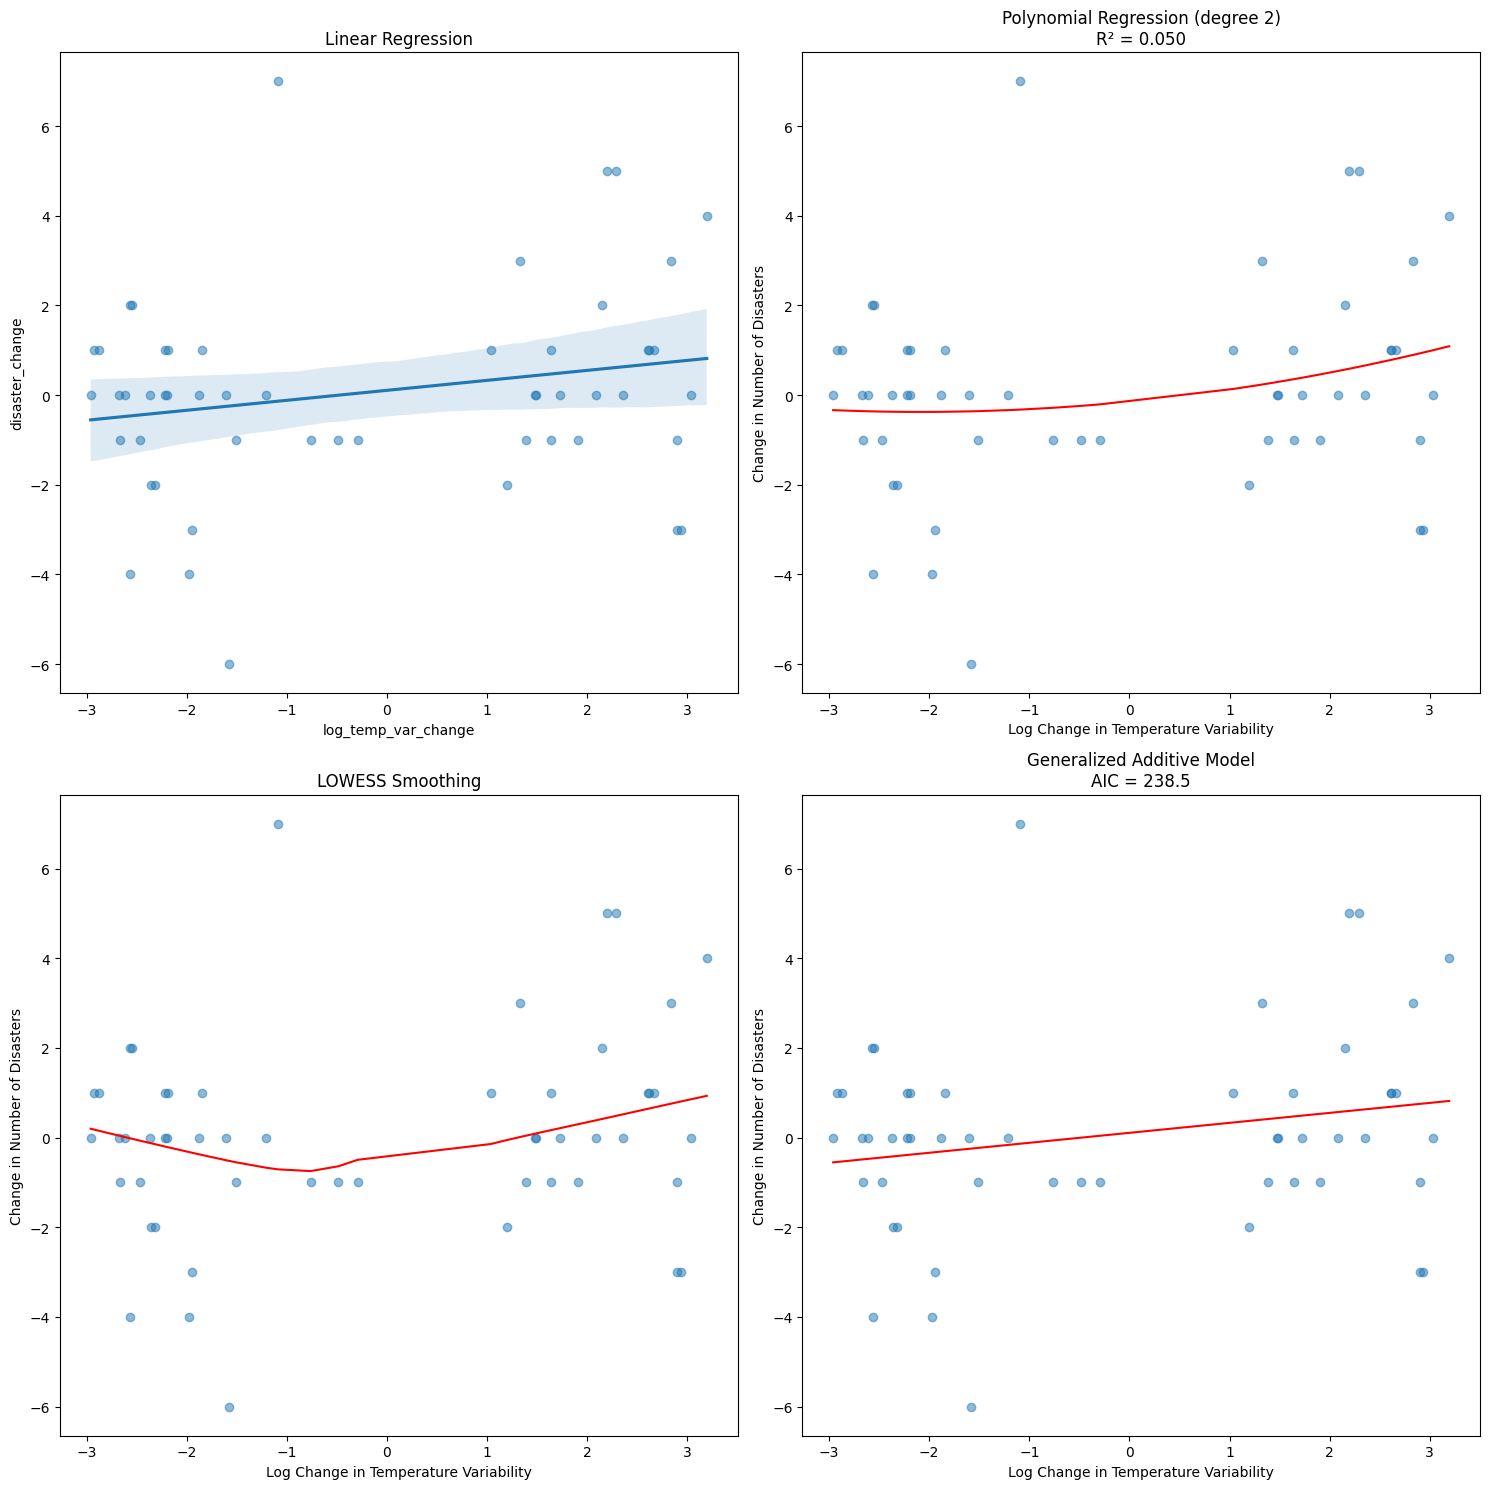


Model Comparison:
1. Linear Regression:
R² = 0.046

2. Polynomial Regression:
R² = 0.050

3. GAM:
AIC = 238.5
Deviance = 259.1


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess

# [Previous data preparation code remains the same until merged dataset]
def log_transform_with_sign(x):
    return np.sign(x) * np.log1p(np.abs(x))

def get_annual_temp_var(min_temp_file, max_temp_file, start_year=1960):
    with open(min_temp_file, 'r') as f:
        min_lines = f.readlines()[11:]
    with open(max_temp_file, 'r') as f:
        max_lines = f.readlines()[11:]
    
    annual_data = []
    for min_line, max_line in zip(min_lines, max_lines):
        try:
            year = int(min_line.strip().split()[-1])
            if year < start_year:
                continue
                
            min_temps = [float(x) for x in min_line.strip().split()[:-1]]
            max_temps = [float(x) for x in max_line.strip().split()[:-1]]
            monthly_ranges = [max_t - min_t for max_t, min_t in zip(max_temps, min_temps)]
            variability = np.std(monthly_ranges)
            
            annual_data.append({
                'year': year,
                'temp_variability': variability
            })
        except (ValueError, IndexError):
            continue
    
    df = pd.DataFrame(annual_data)
    df['temp_var_change'] = df['temp_variability'].diff()
    df['log_temp_var_change'] = log_transform_with_sign(df['temp_var_change'])
    return df

# Get data with 2-year lag
temp_df = get_annual_temp_var('UK_min_temperature_data.txt', 'UK_max_temperature_data.txt')
disaster_df = pd.read_csv('UK Natural Disasters Data - EM-DAT Data.csv')

annual_disasters = disaster_df.groupby('Start Year').size().reset_index(name='disaster_count')
annual_disasters = annual_disasters[annual_disasters['Start Year'] >= 1960]
year_range = pd.DataFrame({'Start Year': range(annual_disasters['Start Year'].min(),
                                             annual_disasters['Start Year'].max() + 1)})
annual_disasters = pd.merge(year_range, annual_disasters, on='Start Year', how='left')
annual_disasters['disaster_count'] = annual_disasters['disaster_count'].fillna(0)
annual_disasters['disaster_change'] = annual_disasters['disaster_count'].diff()

# Create 2-year lagged dataset
lag = 2
temp_lagged = temp_df.copy()
temp_lagged['year'] = temp_lagged['year'] + lag
merged = pd.merge(temp_lagged, annual_disasters, 
                 left_on='year', 
                 right_on='Start Year',
                 how='inner')
merged = merged.replace([np.inf, -np.inf], np.nan).dropna()

# Create figure with multiple plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

# 1. Linear regression (baseline)
sns.regplot(x='log_temp_var_change', y='disaster_change', data=merged,
            ax=ax1, scatter_kws={'alpha':0.5})
ax1.set_title('Linear Regression')

# 2. Polynomial regression (degree 2)
X = merged['log_temp_var_change'].values.reshape(-1, 1)
y = merged['disaster_change'].values

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
poly_reg = LinearRegression()
poly_reg.fit(X_poly, y)
X_sort = np.sort(X, axis=0)
X_poly_plot = poly.transform(X_sort.reshape(-1, 1))
y_pred = poly_reg.predict(X_poly_plot)

ax2.scatter(X, y, alpha=0.5)
ax2.plot(X_sort, y_pred, color='red')
ax2.set_title(f'Polynomial Regression (degree 2)\nR² = {r2_score(y, poly_reg.predict(X_poly)):.3f}')
ax2.set_xlabel('Log Change in Temperature Variability')
ax2.set_ylabel('Change in Number of Disasters')

# 3. LOWESS smoothing
lowess_result = lowess(y, X.ravel(), frac=0.6)
ax3.scatter(X, y, alpha=0.5)
ax3.plot(lowess_result[:, 0], lowess_result[:, 1], color='red')
ax3.set_title('LOWESS Smoothing')
ax3.set_xlabel('Log Change in Temperature Variability')
ax3.set_ylabel('Change in Number of Disasters')

# 4. Generalized Additive Model (GAM)
X_gam = sm.add_constant(X)
gam = sm.GLM(y, X_gam, family=sm.families.Gaussian())
gam_results = gam.fit()
ax4.scatter(X, y, alpha=0.5)
ax4.plot(X_sort, gam_results.predict(sm.add_constant(X_sort)), color='red')
ax4.set_title(f'Generalized Additive Model\nAIC = {gam_results.aic:.1f}')
ax4.set_xlabel('Log Change in Temperature Variability')
ax4.set_ylabel('Change in Number of Disasters')

plt.tight_layout()
plt.show()

# Print model comparison statistics
print("\nModel Comparison:")
print("1. Linear Regression:")
linear_reg = LinearRegression().fit(X, y)
print(f"R² = {r2_score(y, linear_reg.predict(X)):.3f}")

print("\n2. Polynomial Regression:")
print(f"R² = {r2_score(y, poly_reg.predict(X_poly)):.3f}")

print("\n3. GAM:")
print(f"AIC = {gam_results.aic:.1f}")
print(f"Deviance = {gam_results.deviance:.1f}")